In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [5]:
# path = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi/fs_TBN035/mri/"

In [6]:
# t1_path = path+"T1.mgz"
# aseg_path = path+"aseg.mgz"
# orig_path = path+"orig/001.mgz"

In [7]:
# t1_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(t1_path)
# t1 = t1_img.get_data()

# t1_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
# aseg = t1_img.get_data()

# t1_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(orig_path)
# orig = t1_img.get_data()


In [8]:
# print(t1.shape)
# print(aseg.shape)
# print(orig.shape)

In [9]:
# orig.shape

In [10]:
# plt.imshow(orig[:,:,100])
# plt.show()

In [11]:
# plt.imshow(t1[:,100,:])
# plt.show()

In [12]:
# plt.imshow(aseg[:,100,:])
# plt.show()

In [ ]:
# orig.shape

In [13]:
# saved = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/"
# for i in range(256):
#     print(i)
#     t1_i = t1[:,i,:].reshape((1,256,256))
#     aseg_i = aseg[:,i,:].reshape((1,256,256))
    
#     print("t1",t1_i.shape)
#     print("aseg",aseg_i.shape)
#     ltr_t1_mgz = nibabel.freesurfer.mghformat.MGHImage(t1_i, None)
#     save_path = saved+"t1/image"+str(i)+".mgz"
#     nibabel.save(ltr_t1_mgz, save_path)
    
#     ltr_t1_mgz = nibabel.freesurfer.mghformat.MGHImage(aseg_i, None)
#     save_path = saved+"aseg/image"+str(i)+".mgz"
#     nibabel.save(ltr_t1_mgz, save_path)

#     if i>=192:
#         continue
#     else:
#         orig_i = orig[:,:,i].reshape((1,256,256))
#         print("orig",orig_i.shape)
#         ltr_t1_mgz = nibabel.freesurfer.mghformat.MGHImage(orig_i, None)
#         save_path = saved+"orig/image"+str(i)+".mgz"
#         nibabel.save(ltr_t1_mgz, save_path)

In [14]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [67]:
rest_available = [2 , 3, 7, 8, 41, 42, 46, 47]

## 10 Segments

### Left-Cerebral-White-Matter
### Left-Cerebral-Cortex
### Left-Cerebellum-White-Matter
### Left-Cerebellum-Cortex
### Right-Cerebral-White-Matter
### Right-Cerebral-Cortex
### Right-Cerebellum-White-Matter
### Right-Cerebellum-Cortex

In [16]:
num_seg = len(rest_available)+1

In [17]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [18]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [19]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [20]:
model = torch.load("./brain_segmentation/10seg_try5_2")

In [21]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [22]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/orig/"+ self.image_dir[idx]
        aseg_path = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/aseg/"+ self.image_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = np.array(im, np.float64, copy=False)
        
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im)
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [23]:
names = os.listdir("/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/orig/")

In [70]:
cd = True
transformed_dataset = {'validate':BrainImages(np.array(names),np.array(names),coord=cd)}

bs = 10

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['validate']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['validate']}

In [72]:
orig_data = next(iter(dataloader["validate"]))

In [73]:
orig_data['x'].size()

torch.Size([10, 3, 256, 256])

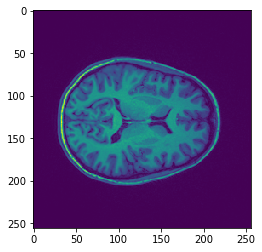

In [74]:
plt.imshow(orig_data['x'][0,0,:,:])

In [75]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [76]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [77]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    
    output = model(x)
    for i in range(bs):
        plt.imshow(x[i,0,:,:])
        plt.show()
#         print('-'*100)
#         print('Ground Truth')
#         abc = data['y'][i,:,:,:]
#         bcd = abc.unsqueeze(1)
#         show(make_grid(bcd,padding=10,pad_value=1)) 
#         print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

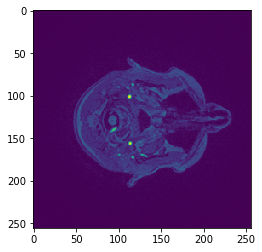

Prediction


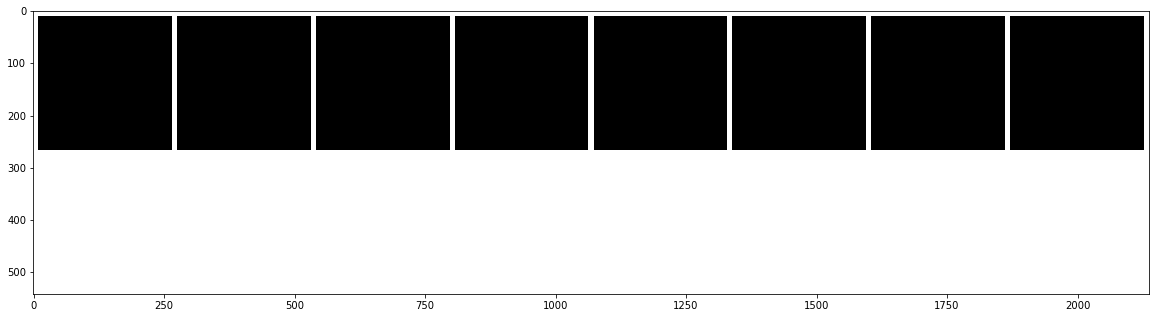

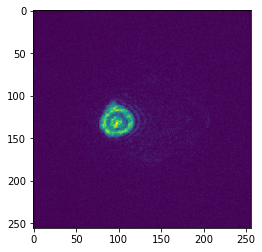

Prediction


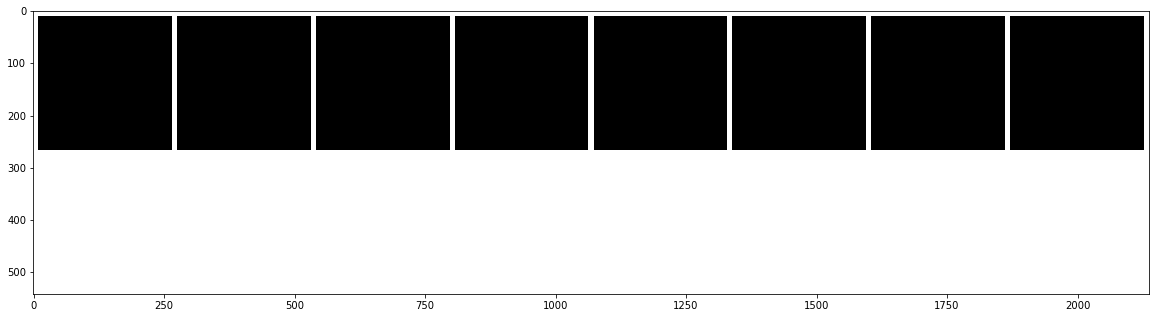

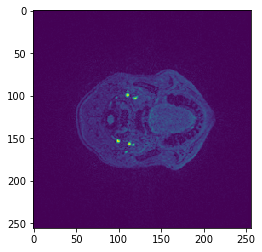

Prediction


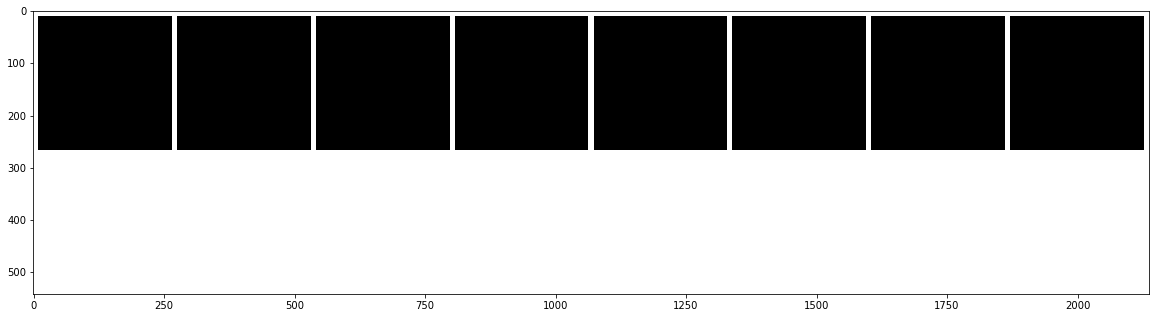

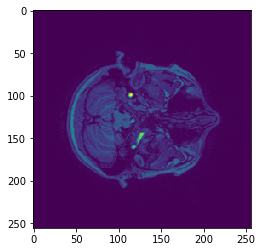

Prediction


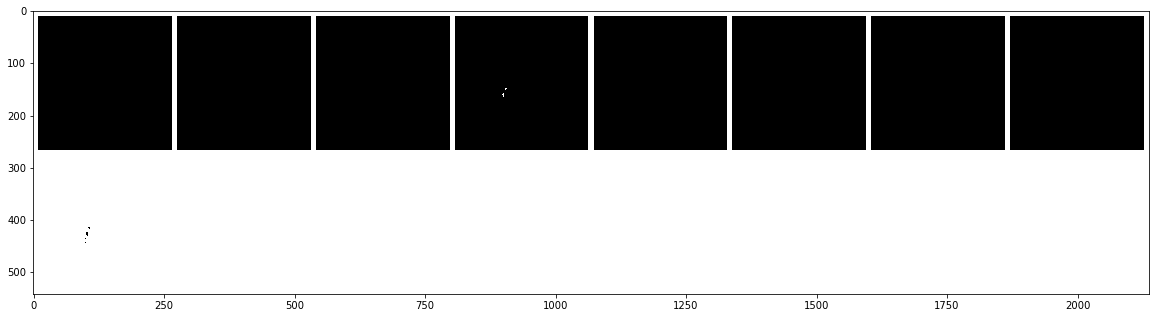

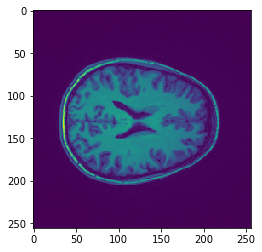

Prediction


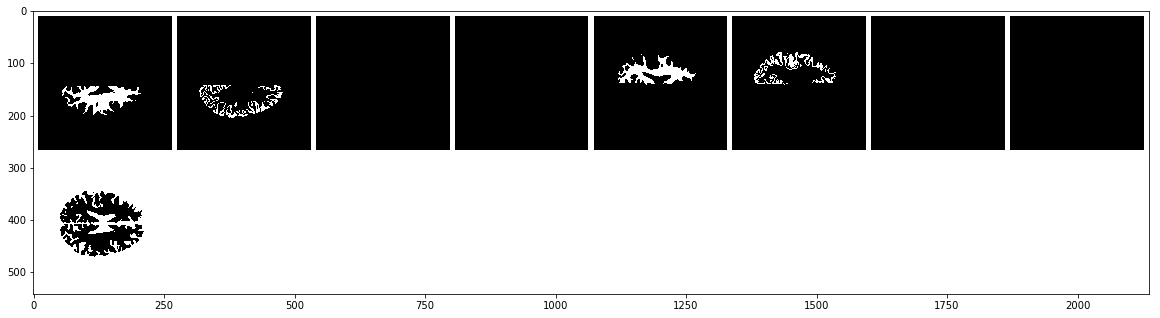

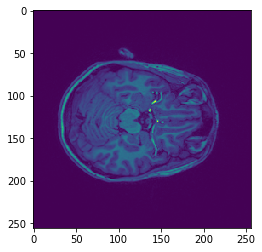

Prediction


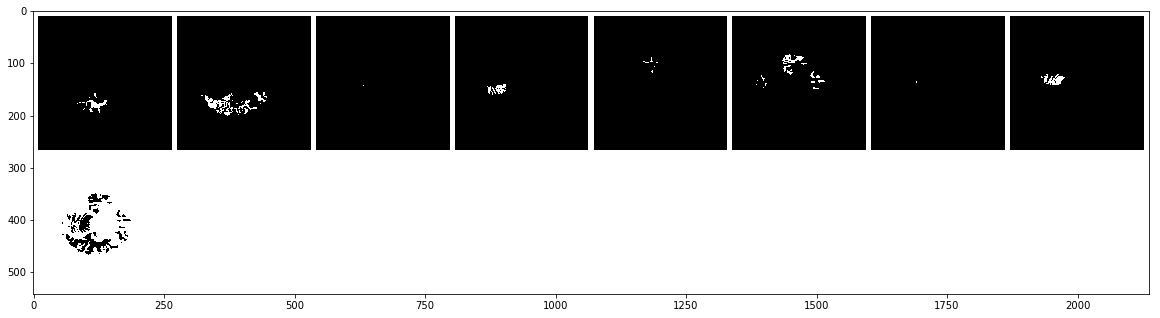

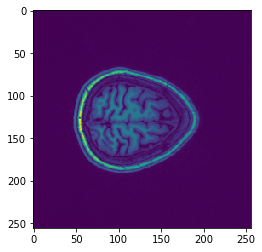

Prediction


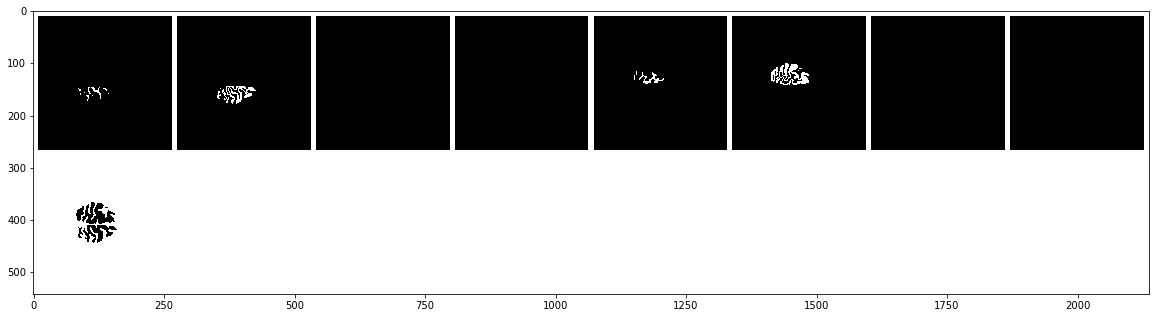

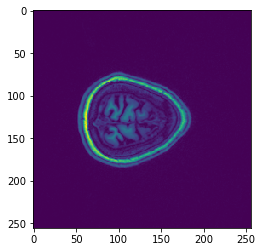

Prediction


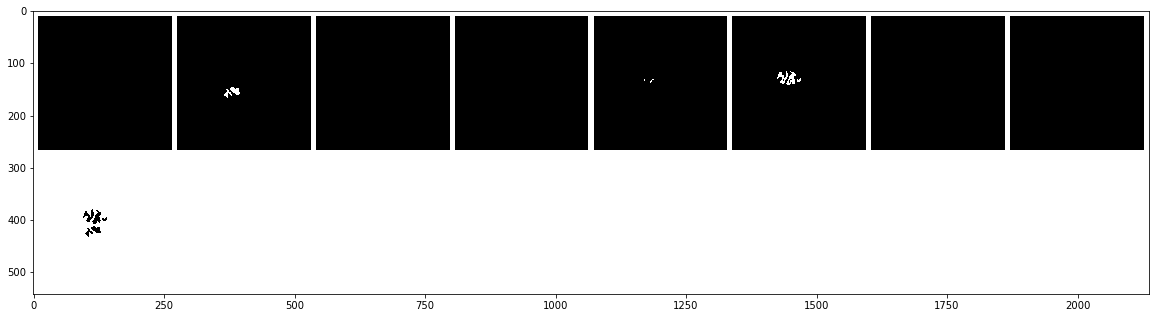

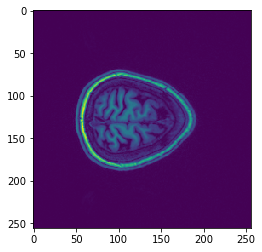

Prediction


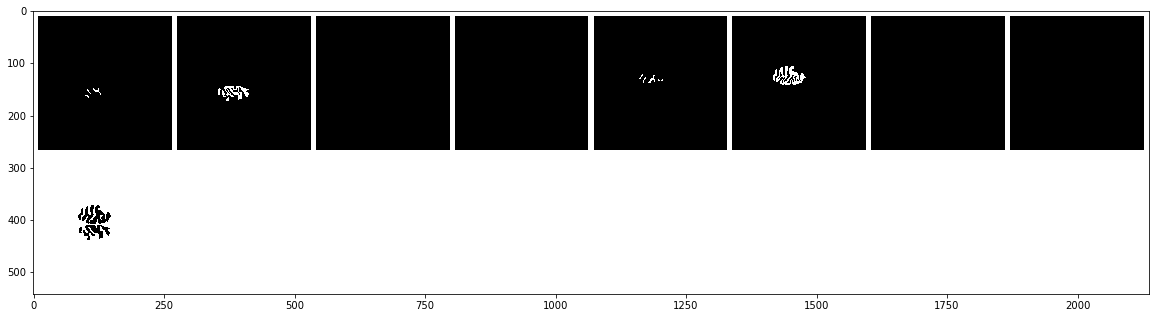

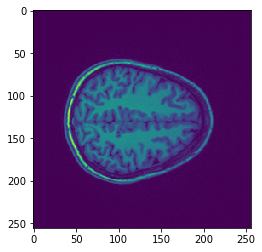

Prediction


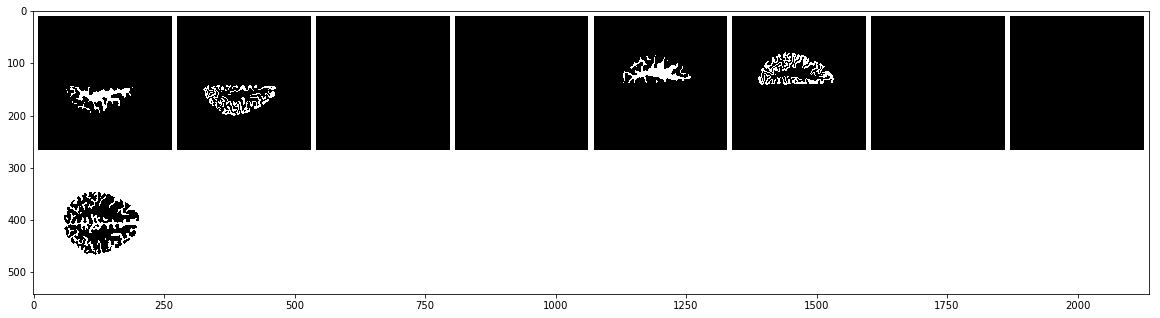

In [78]:
visualize_few()

In [79]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).cpu().numpy()

In [80]:
colors = ['viridis','plasma','summer','hsv','spring','Wistia','Pastel1','tab20c']

In [81]:
def visualize_tissue(list_segs):
    print("\t \t Original MRI \t \t  \t \t \t \t Predictions")
    inputs = next(iter(dataloader['validate']))
    model.train(False)
    x = inputs['x']
    x = Variable(x).cuda()
    output = model(x)
    
    for j in range(bs):
        imgs_masked = [0]*44
        out_masked = [0]*44
        inp_img = inputs['y'][j,:,:,:].numpy()
        out_img = visualize1(output[j,:,:,:])
        
        if np.sum(inp_img[-1,:,:] == 256*256):
            continue
        if np.isnan(np.sum(inputs['x'][j,0,:,:].numpy())):
            continue
        
        for i in list_segs:
            imgs_masked[i] = np.ma.masked_where(inp_img[i,:,:] == 0, inp_img[i,:,:])
            out_masked[i] = np.ma.masked_where(out_img[i,:,:] == 0, out_img[i,:,:])
            
    
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
#         plt.subplot(1,3,2)
#         plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        

#         for i in list_segs:
#             if np.sum(imgs_masked[i]) != 0:
#                 plt.imshow(imgs_masked[i], colors[i], interpolation='none', alpha=0.9)
                
        plt.subplot(1,2,2)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
        for i in list_segs:
            if np.sum(out_masked[i]) !=0:
                plt.imshow(out_masked[i], colors[i], interpolation='none', alpha=0.9)
        
        plt.show()
        print('-'*120)

	 	 Original MRI 	 	  	 	 	 	 Predictions


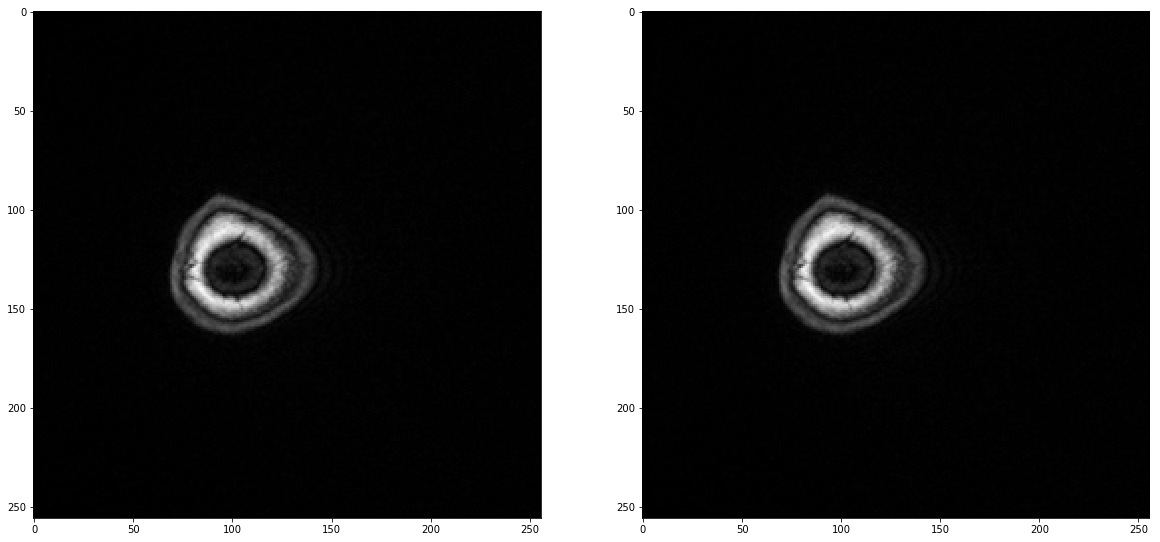

------------------------------------------------------------------------------------------------------------------------


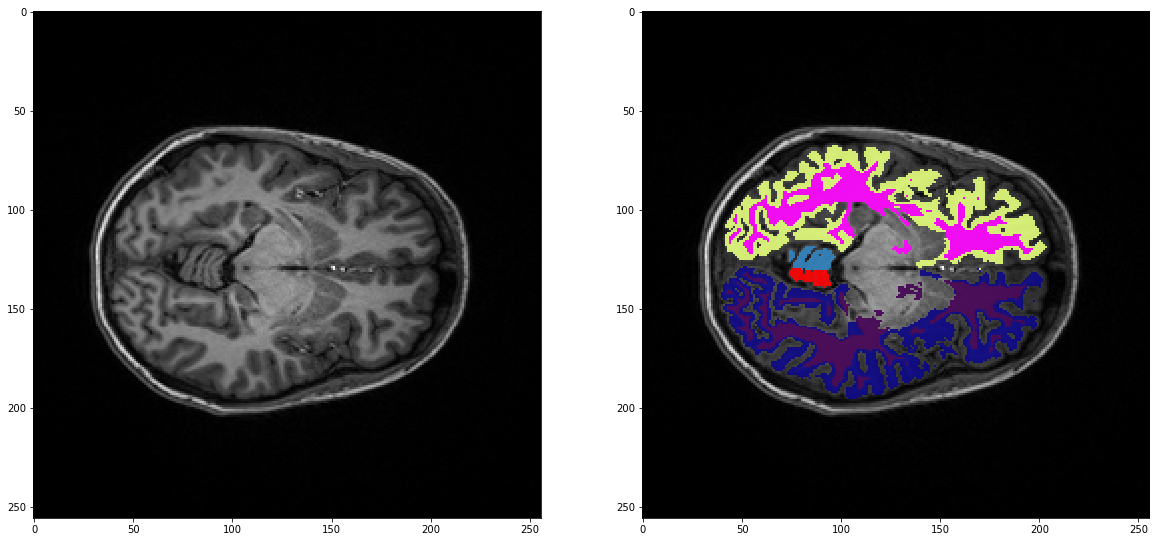

------------------------------------------------------------------------------------------------------------------------


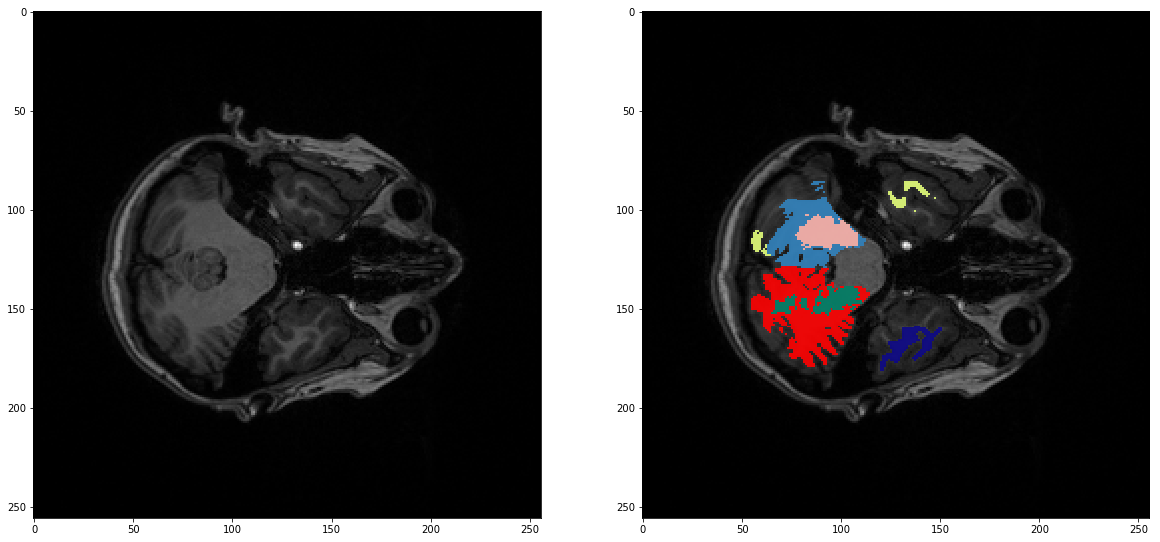

------------------------------------------------------------------------------------------------------------------------


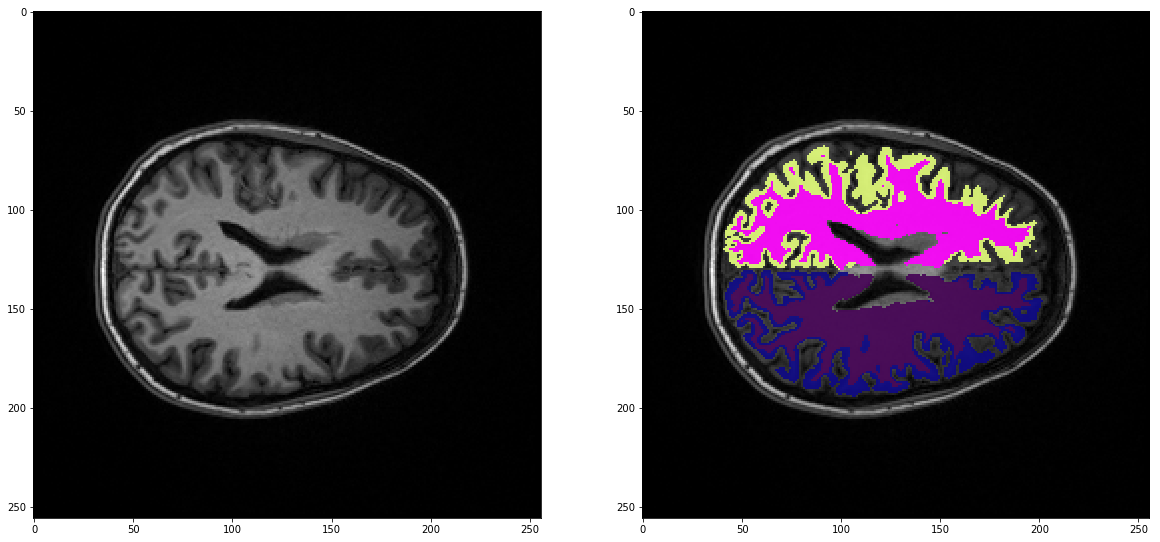

------------------------------------------------------------------------------------------------------------------------


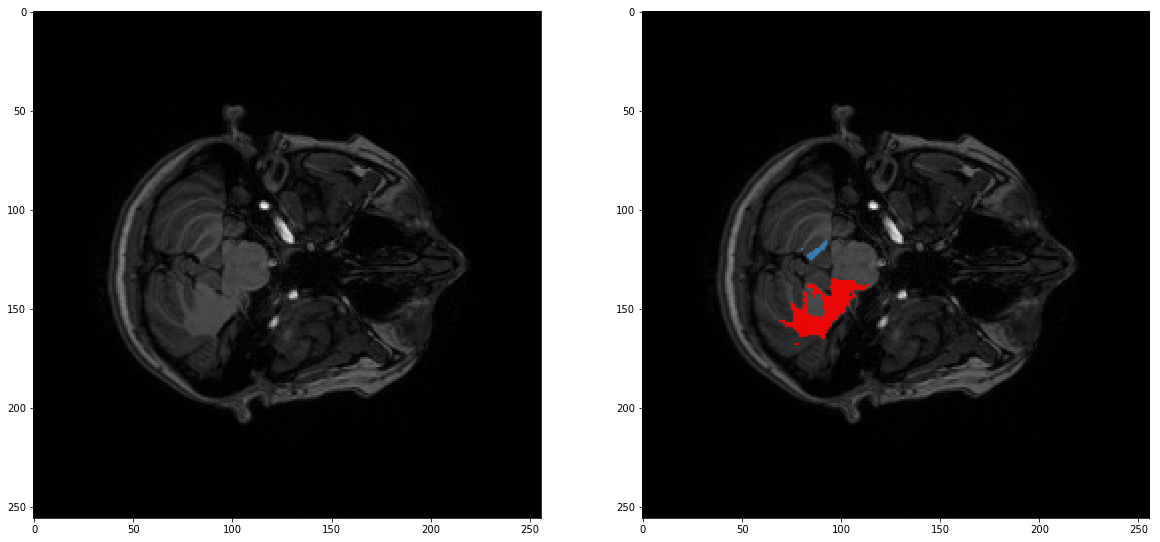

------------------------------------------------------------------------------------------------------------------------


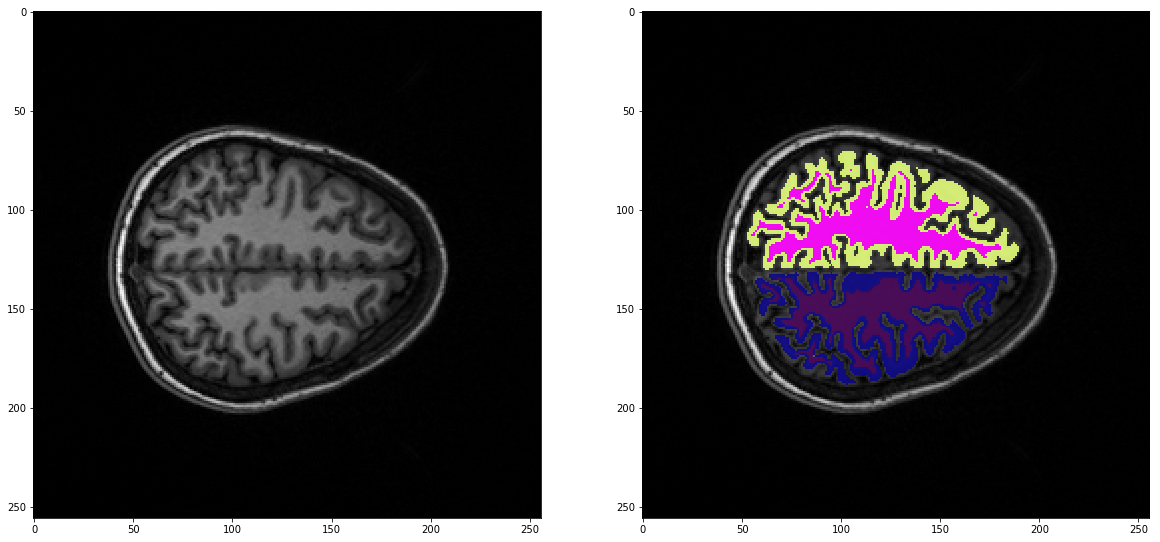

------------------------------------------------------------------------------------------------------------------------


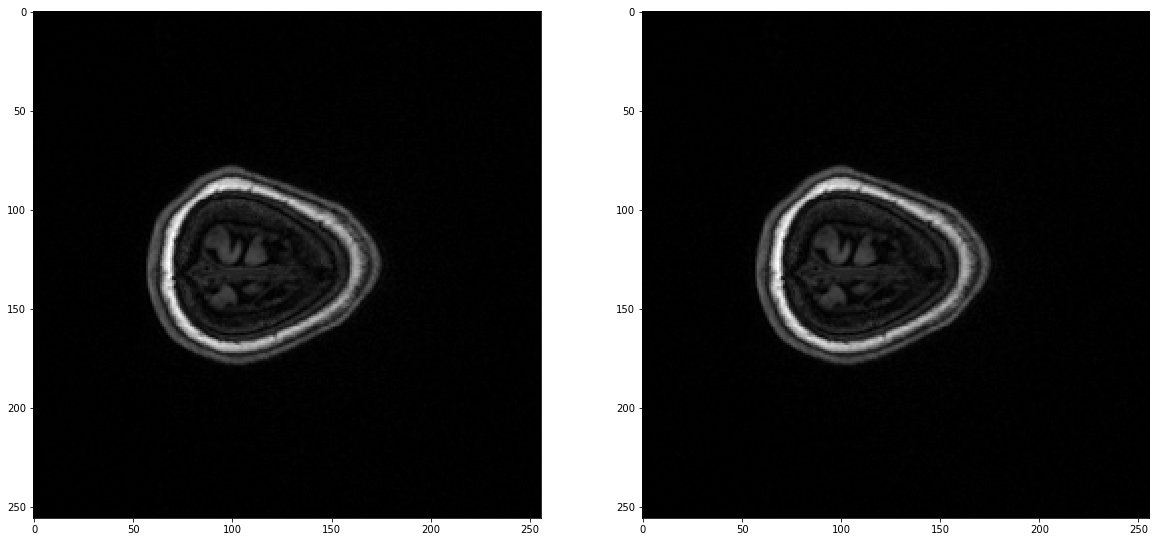

------------------------------------------------------------------------------------------------------------------------


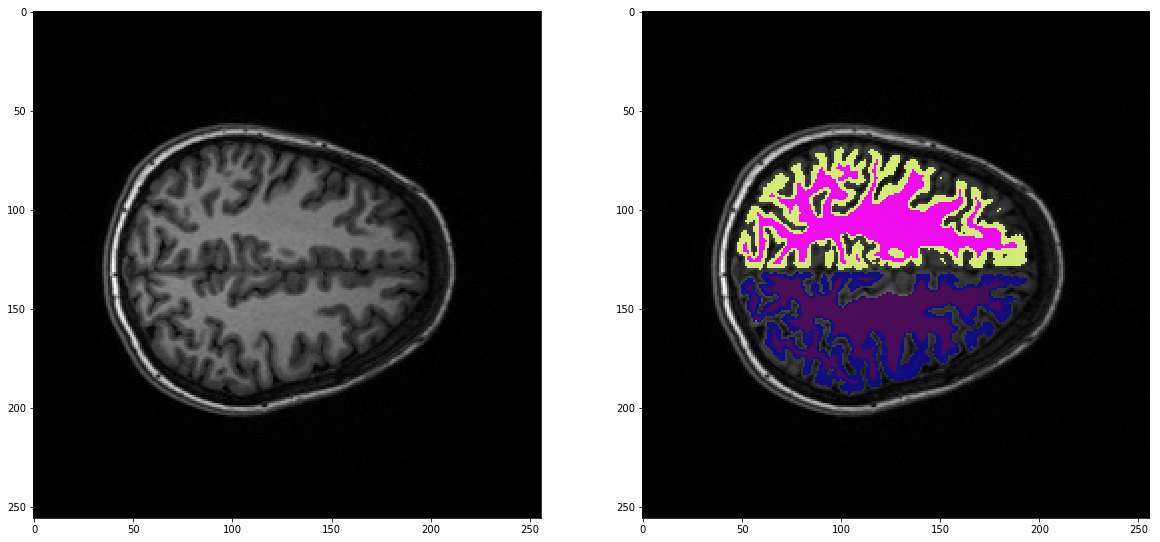

------------------------------------------------------------------------------------------------------------------------


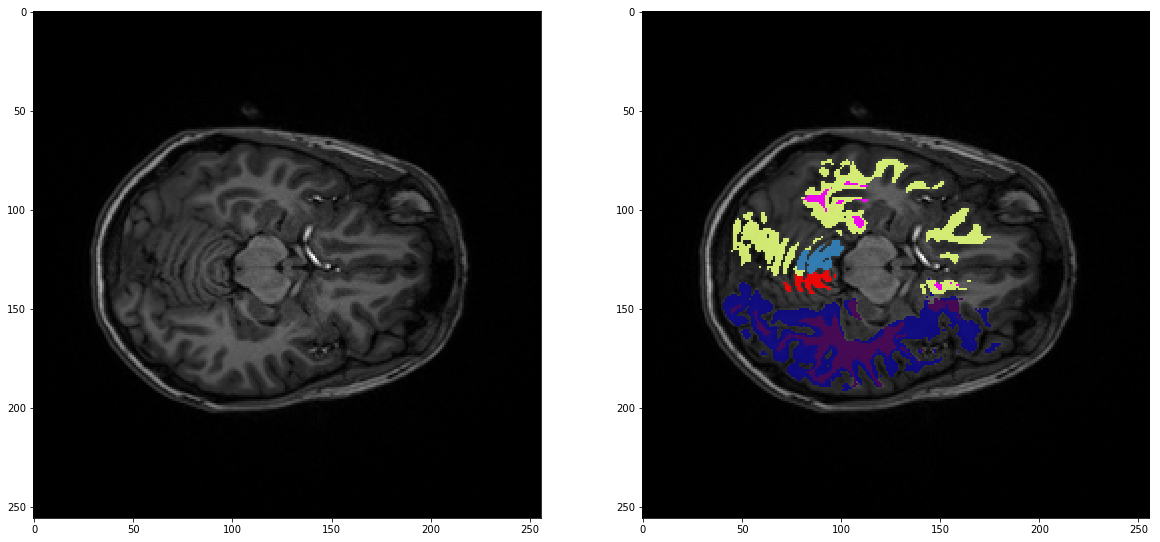

------------------------------------------------------------------------------------------------------------------------


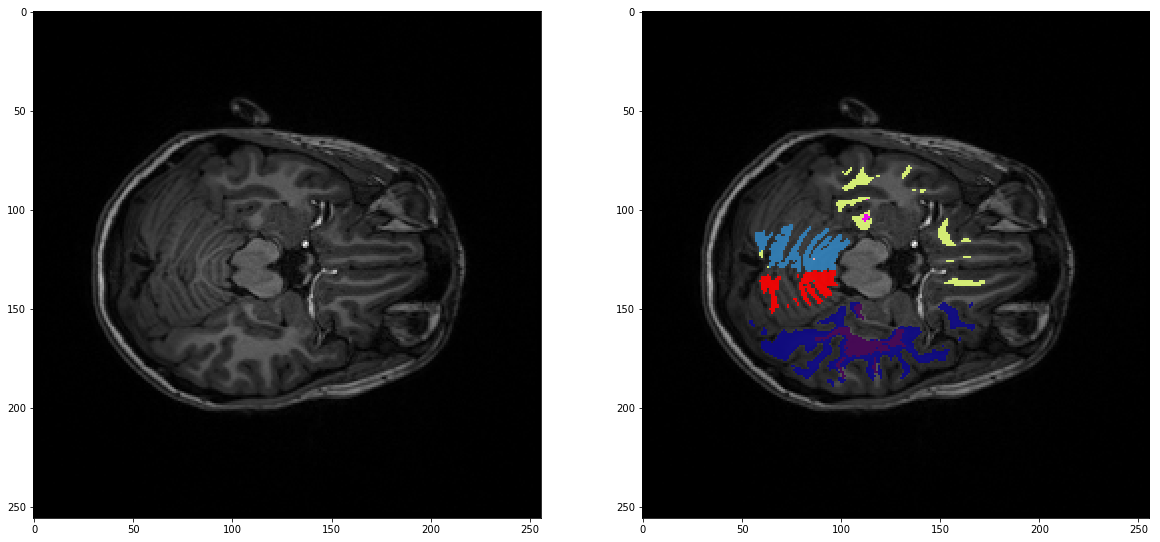

------------------------------------------------------------------------------------------------------------------------


In [82]:
visualize_tissue([0,1,2,3,4,5,6,7])

	 	 Original MRI 	 	  	 	 	 	 Predictions


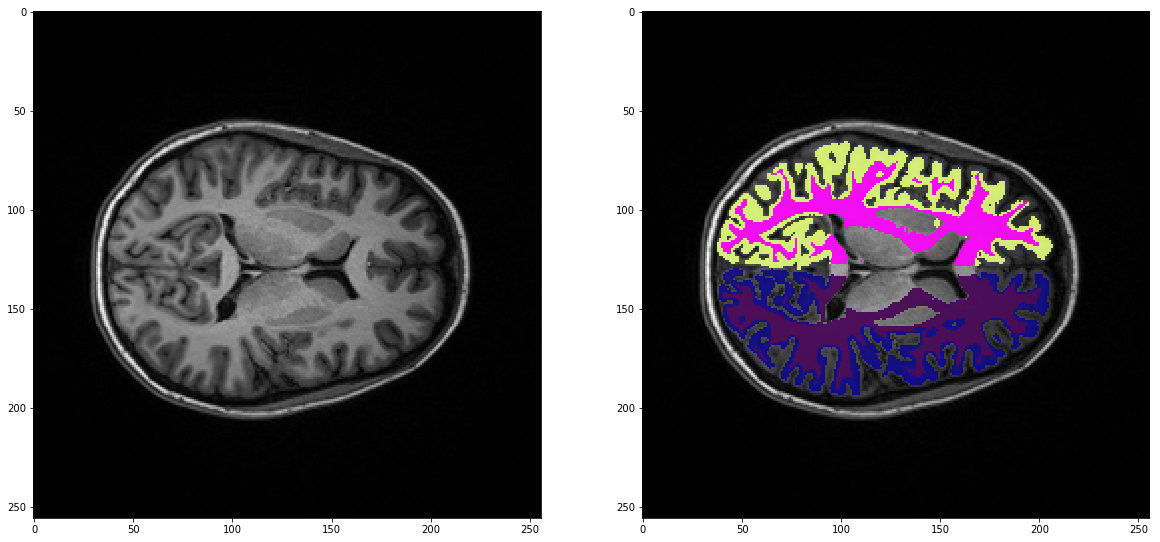

------------------------------------------------------------------------------------------------------------------------


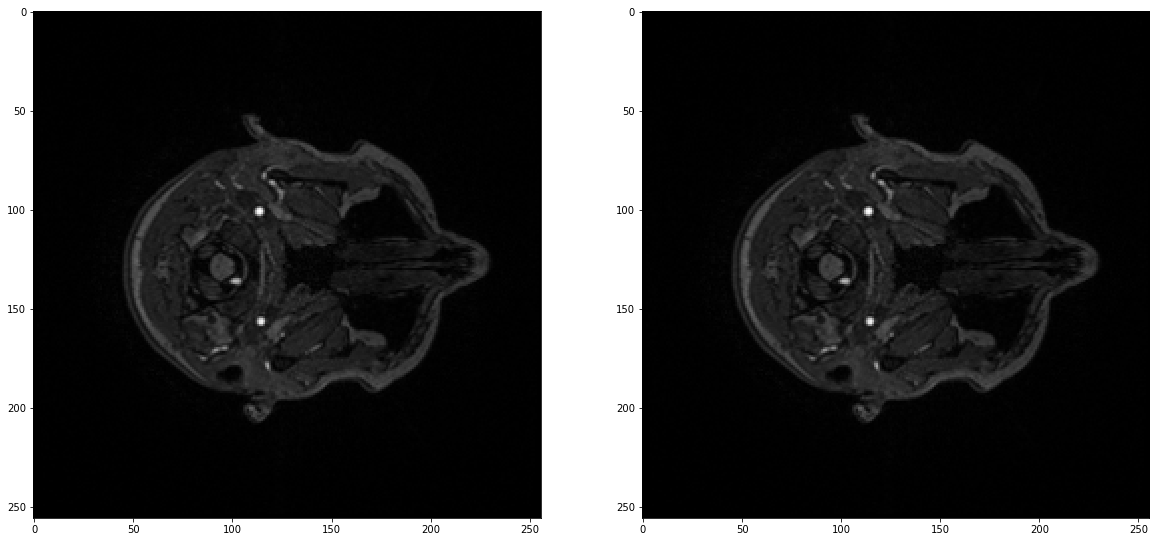

------------------------------------------------------------------------------------------------------------------------


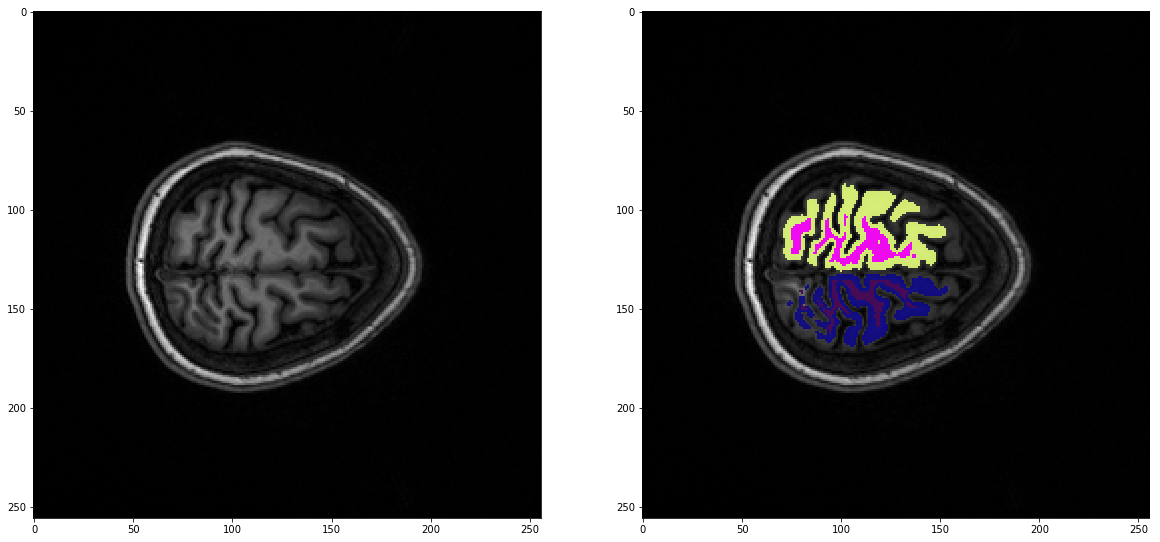

------------------------------------------------------------------------------------------------------------------------


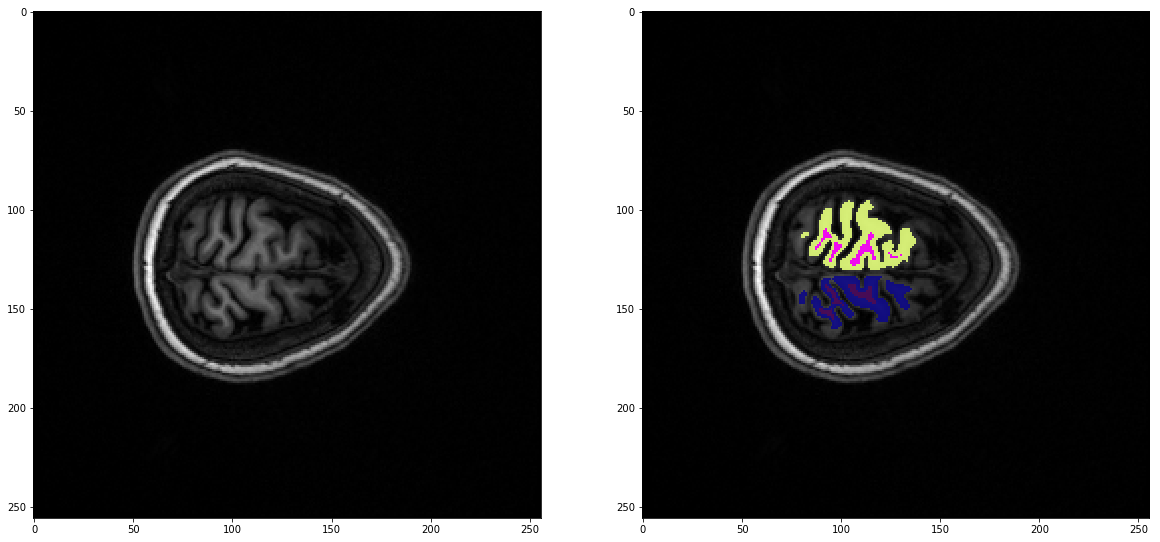

------------------------------------------------------------------------------------------------------------------------


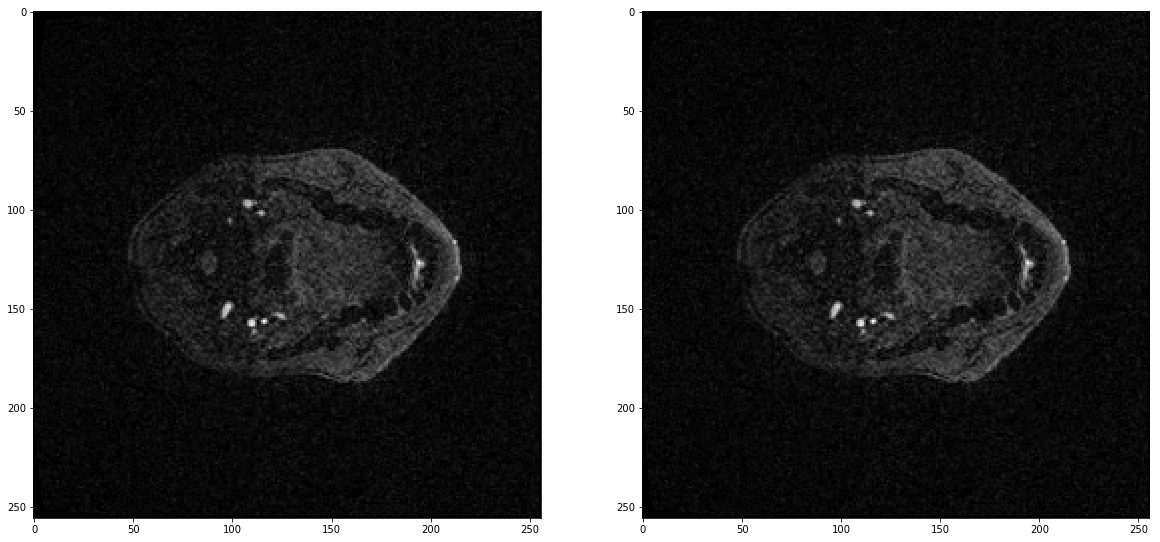

------------------------------------------------------------------------------------------------------------------------


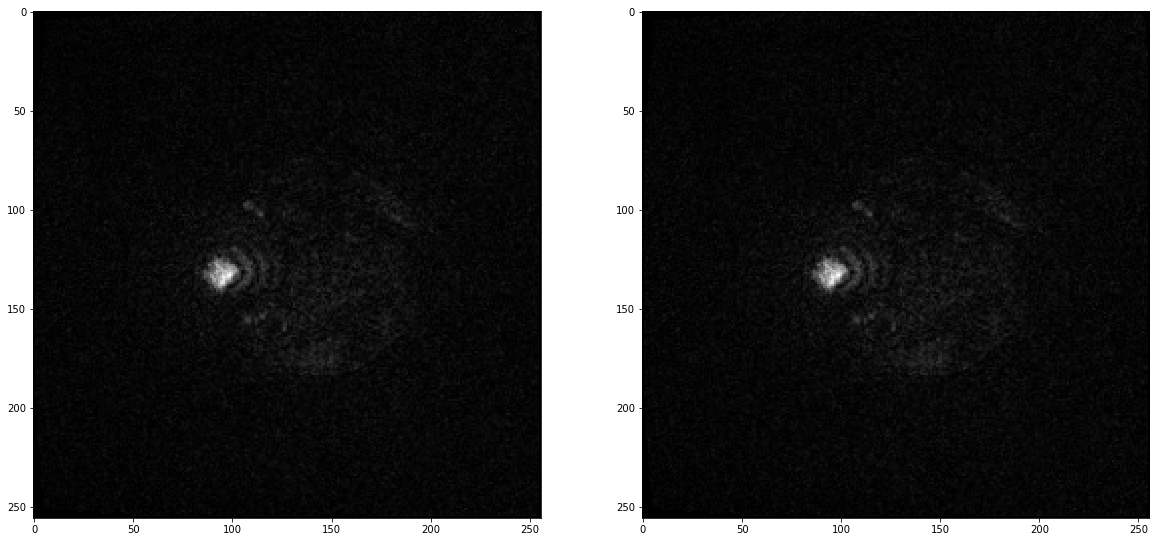

------------------------------------------------------------------------------------------------------------------------


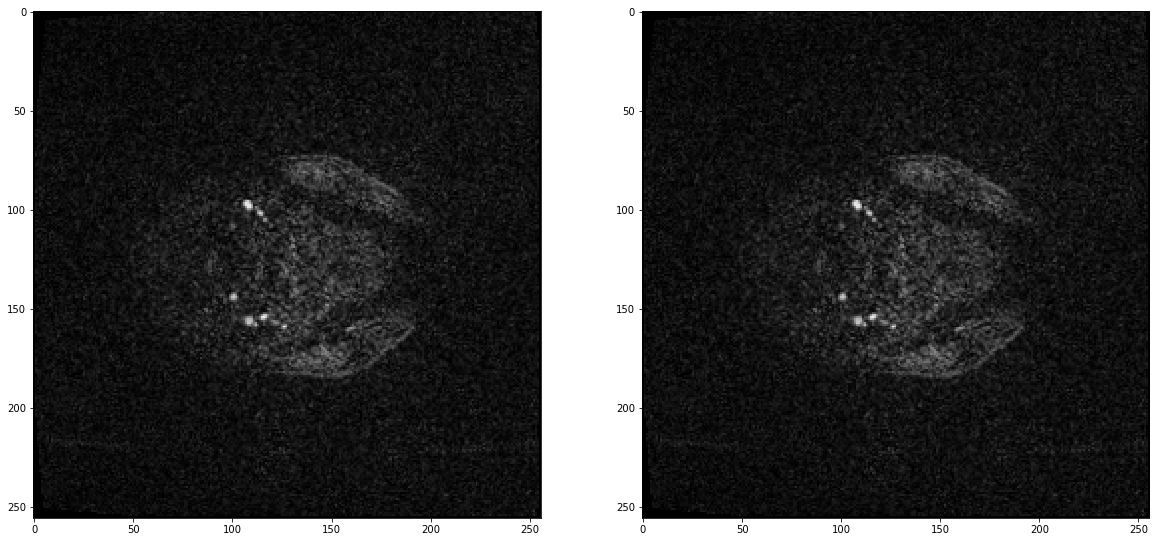

------------------------------------------------------------------------------------------------------------------------


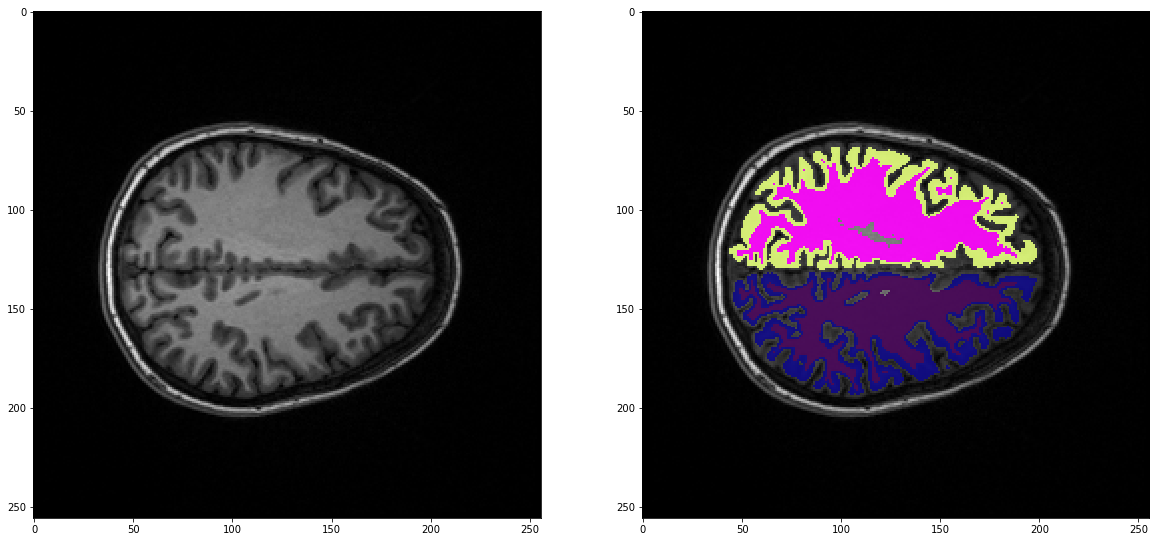

------------------------------------------------------------------------------------------------------------------------


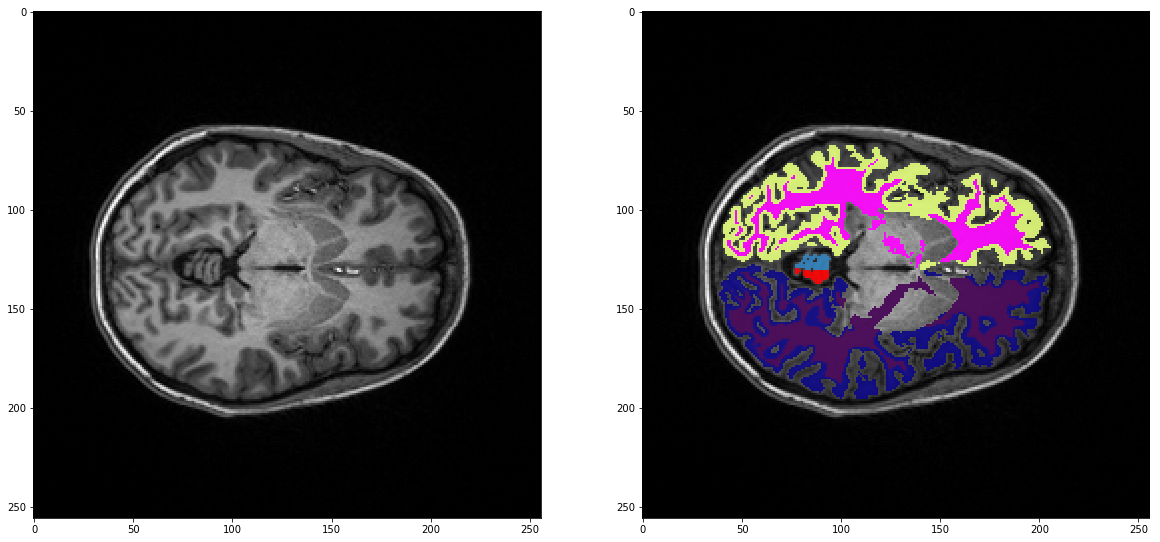

------------------------------------------------------------------------------------------------------------------------


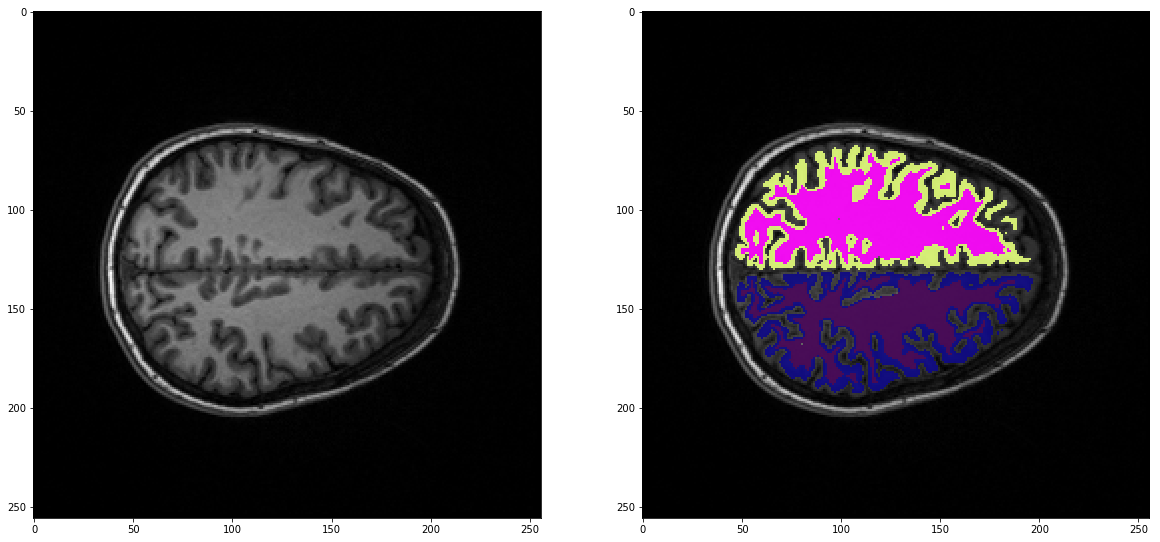

------------------------------------------------------------------------------------------------------------------------


In [83]:
visualize_tissue([0,1,2,3,4,5,6,7])

	 	 Original MRI 	 	  	 	 	 	 Predictions


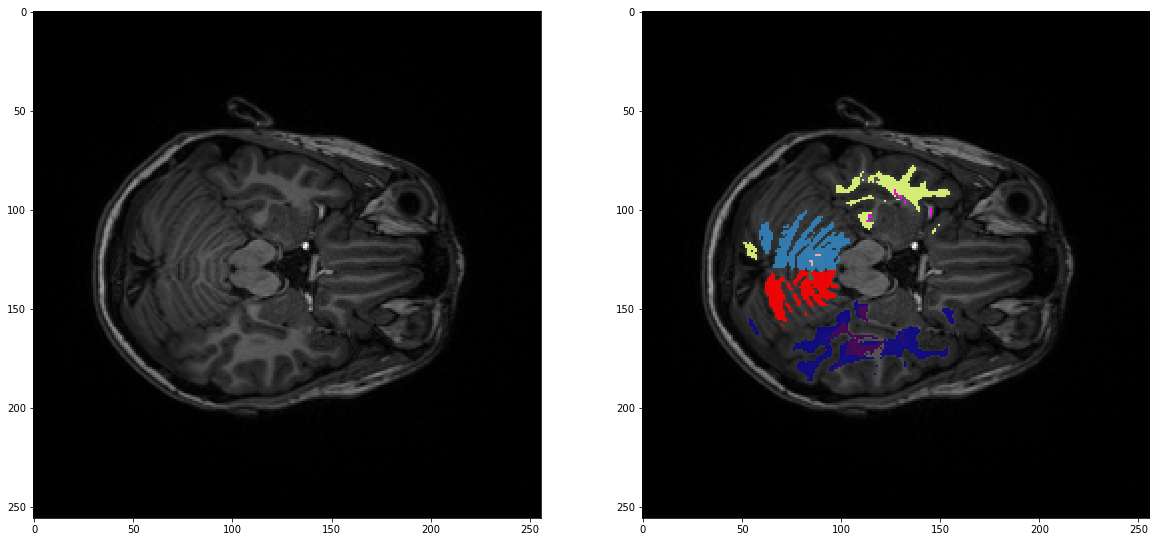

------------------------------------------------------------------------------------------------------------------------


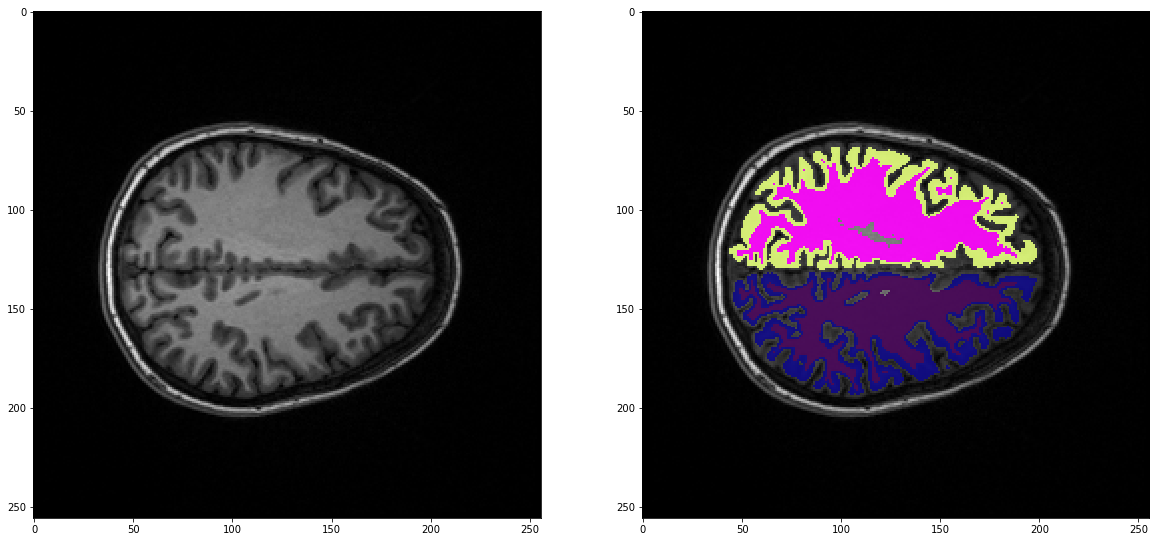

------------------------------------------------------------------------------------------------------------------------


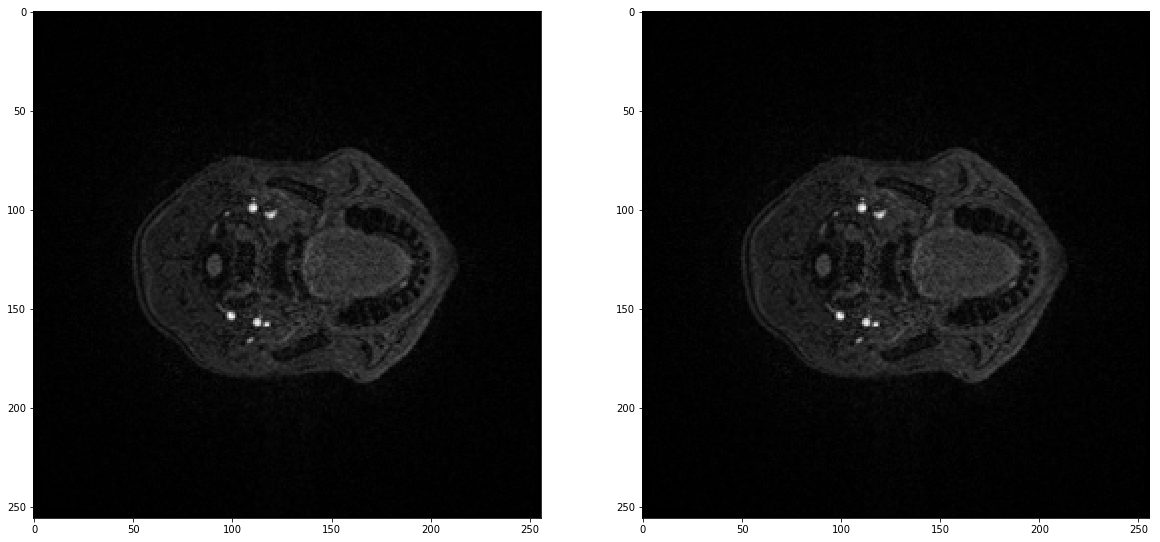

------------------------------------------------------------------------------------------------------------------------


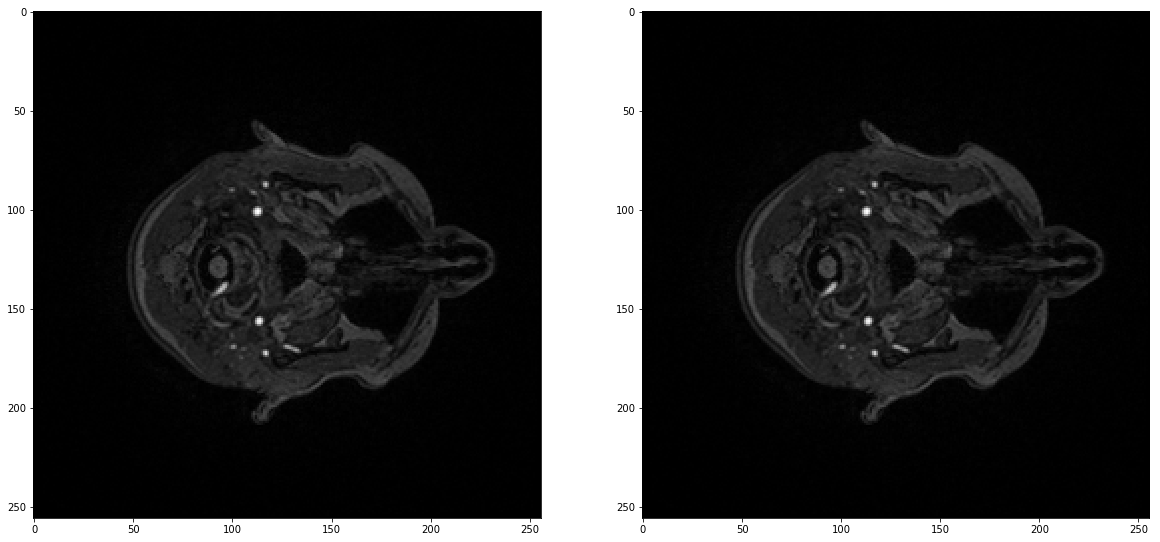

------------------------------------------------------------------------------------------------------------------------


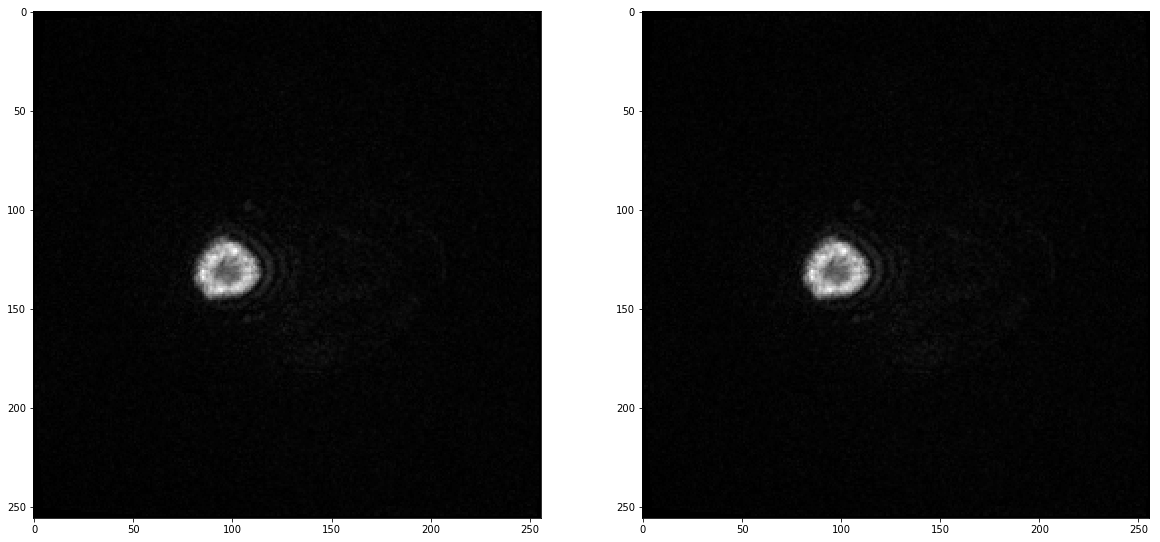

------------------------------------------------------------------------------------------------------------------------


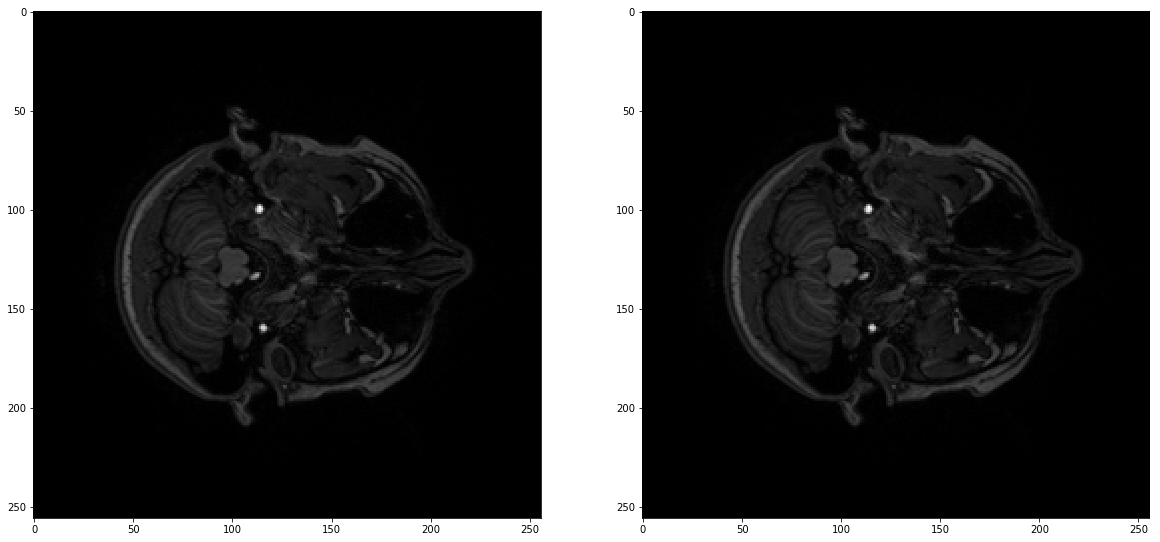

------------------------------------------------------------------------------------------------------------------------


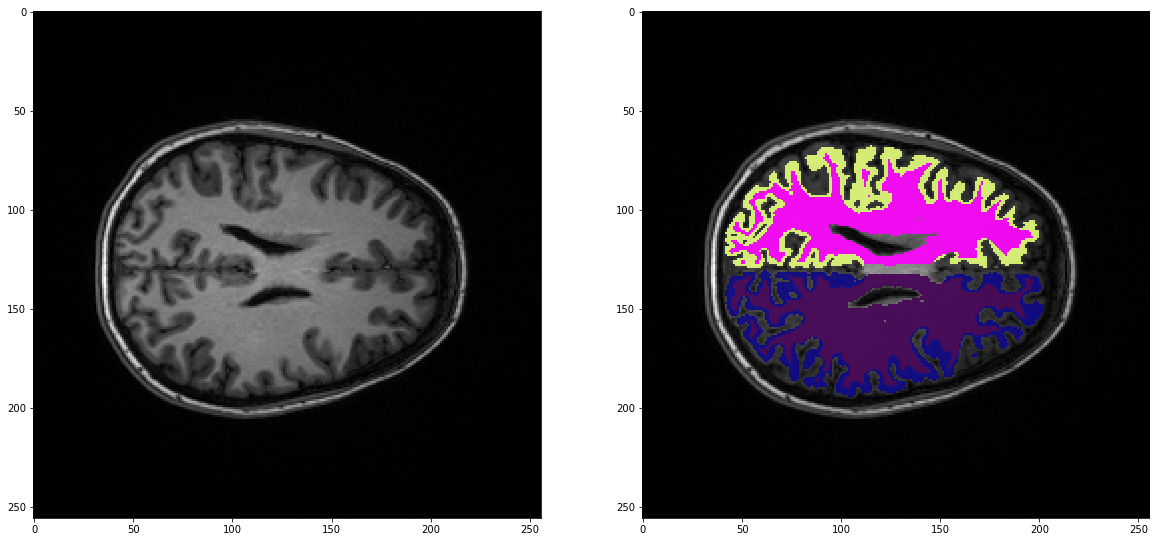

------------------------------------------------------------------------------------------------------------------------


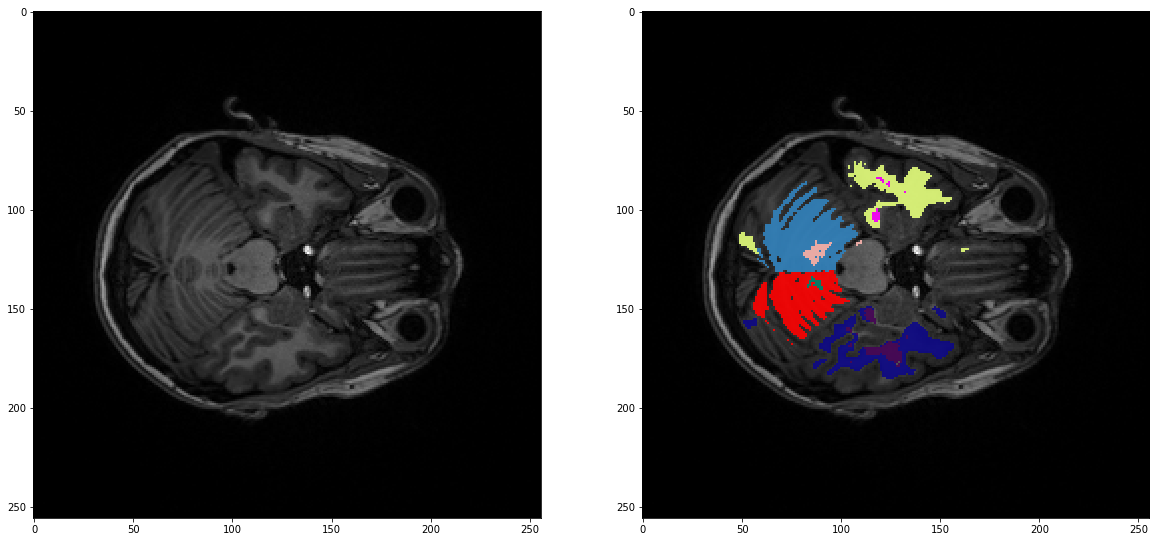

------------------------------------------------------------------------------------------------------------------------


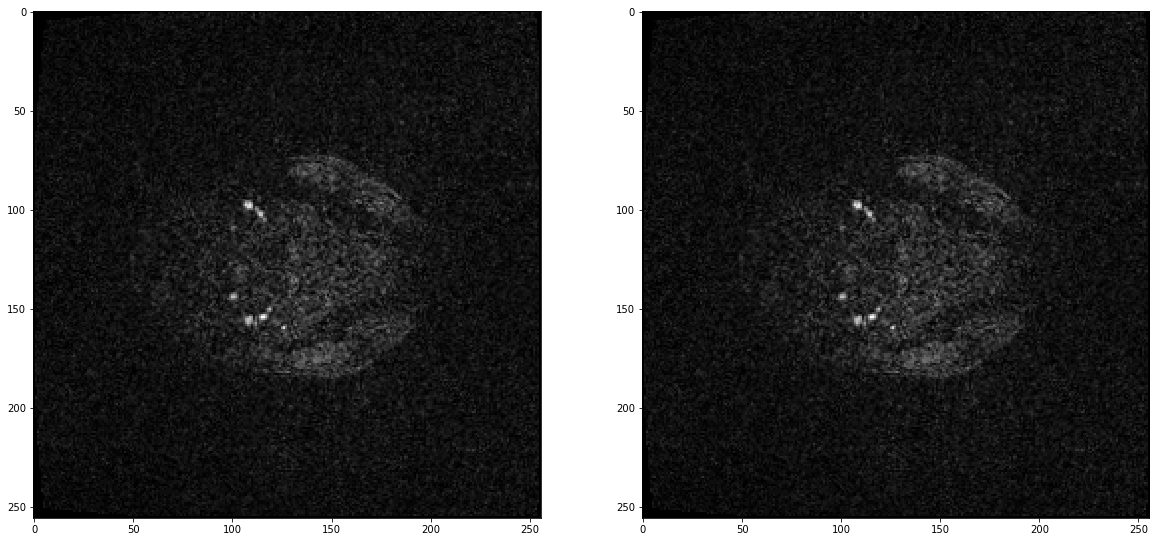

------------------------------------------------------------------------------------------------------------------------


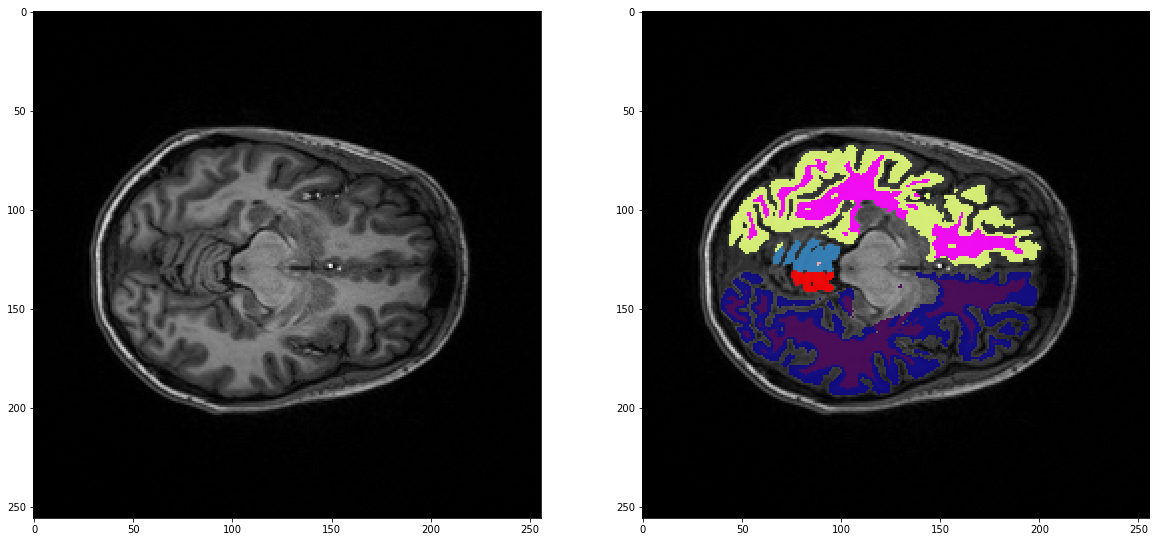

------------------------------------------------------------------------------------------------------------------------


In [84]:
visualize_tissue([0,1,2,3,4,5,6,7])

# 13 Segment Model

### Left-Thalamus-Proper
### Left-Caudate
### Left-Putamen
### Left-Pallidum
### Left-Hippocampus
### Left-Amygdala
### Right-Thalamus-Proper
### Right-Caudate
### Right-Putamen
### Right-Pallidum
### Right-Hippocampus
### Right-Amygdala

In [85]:
rest_available = [10,11,12,13,17,18,49,50,51,52,53,54]

In [86]:
num_seg = len(rest_available)+1

In [91]:
model = torch.load("./brain_segmentation/13_seg_model_2")

In [92]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/orig/"+ self.image_dir[idx]
        aseg_path = "/gpfs/data/cbi/hcp/hcp_seg/data_cbi_extracted/fs_TBN035/aseg/"+ self.image_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = np.array(im, np.float64, copy=False)
        
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im)
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [93]:
cd = True
transformed_dataset = {'validate':BrainImages(np.array(names),np.array(names),coord=cd)}

bs = 10

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['validate']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['validate']}

In [94]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).cpu().numpy()

In [96]:
colors = ['viridis','plasma','summer','Oranges','spring','Wistia','Pastel1','tab20c','winter','coolwarm_r','spring_r','Wistia_r']

In [97]:
def visualize_tissue(list_segs):
    print("\t \t Original MRI \t \t  \t \t \t \t Predictions")
    inputs = next(iter(dataloader['validate']))
    model.train(False)
    x = inputs['x']
    x = Variable(x).cuda()
    output = model(x)
    
    for j in range(bs):
        imgs_masked = [0]*44
        out_masked = [0]*44
        inp_img = inputs['y'][j,:,:,:].numpy()
        out_img = visualize1(output[j,:,:,:])
        
        if np.sum(inp_img[-1,:,:] == 256*256):
            continue
        if np.isnan(np.sum(inputs['x'][j,0,:,:].numpy())):
            continue
        
        for i in list_segs:
            imgs_masked[i] = np.ma.masked_where(inp_img[i,:,:] == 0, inp_img[i,:,:])
            out_masked[i] = np.ma.masked_where(out_img[i,:,:] == 0, out_img[i,:,:])
            
    
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
#         plt.subplot(1,3,2)
#         plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        

#         for i in list_segs:
#             if np.sum(imgs_masked[i]) != 0:
#                 plt.imshow(imgs_masked[i], colors[i], interpolation='none', alpha=0.9)
                
        plt.subplot(1,2,2)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
        for i in list_segs:
            if np.sum(out_masked[i]) !=0:
                plt.imshow(out_masked[i], colors[i], interpolation='none', alpha=0.9)
        
        plt.show()
        print('-'*120)

	 	 Original MRI 	 	  	 	 	 	 Predictions


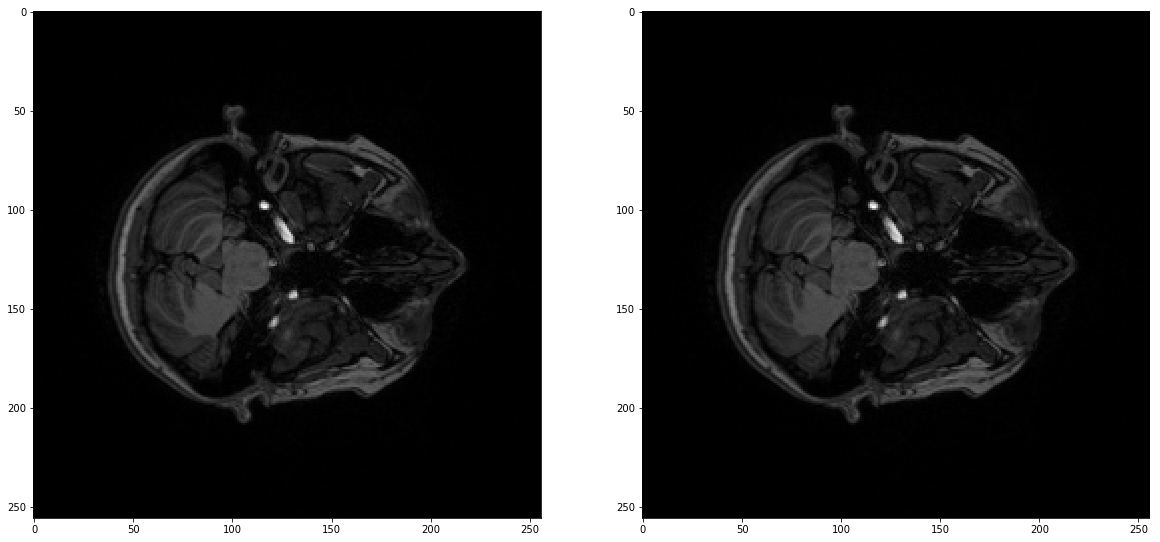

------------------------------------------------------------------------------------------------------------------------


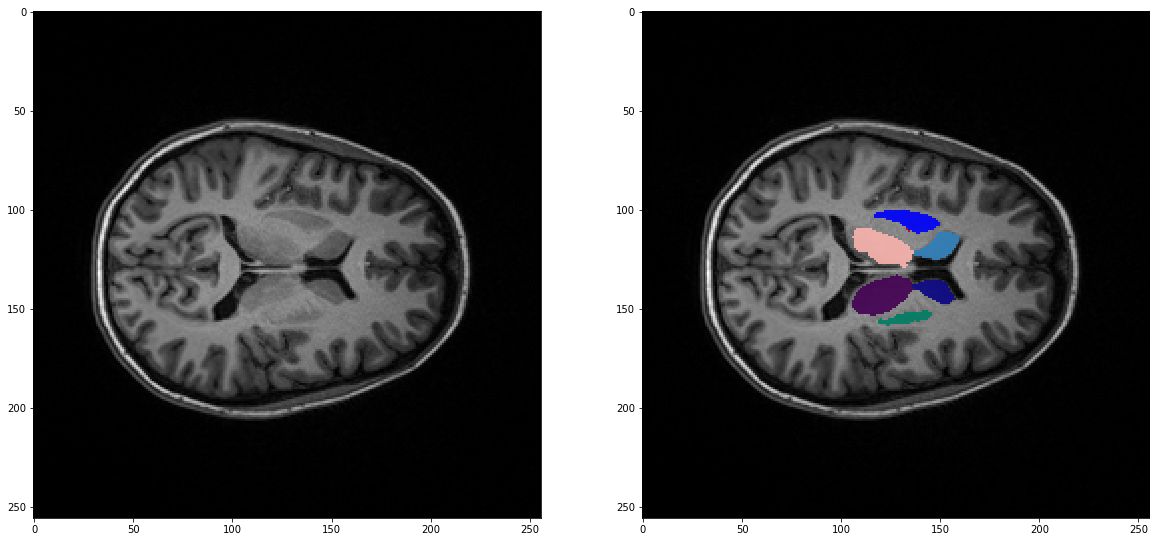

------------------------------------------------------------------------------------------------------------------------


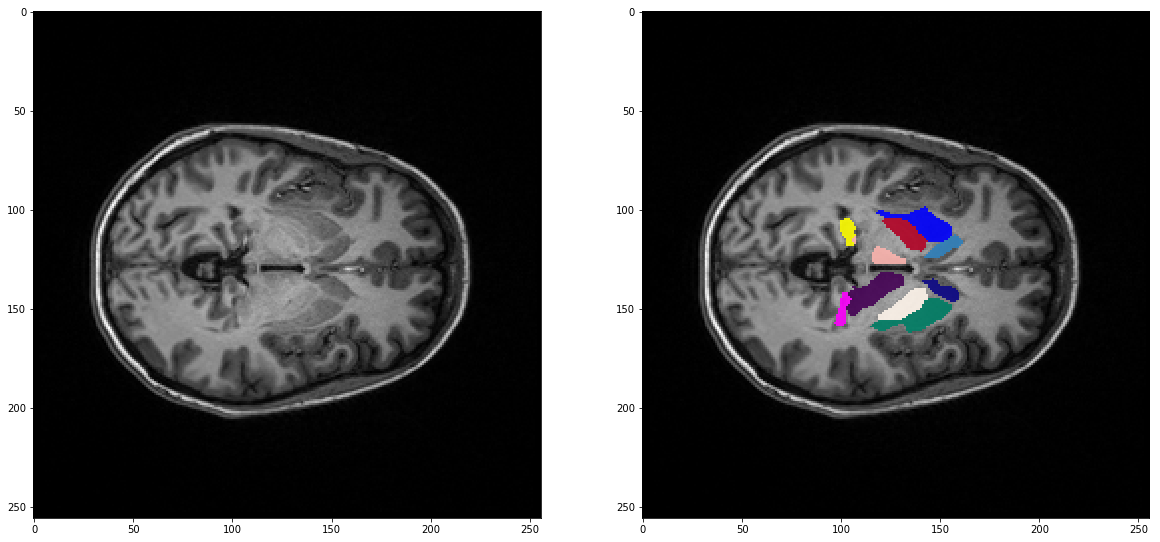

------------------------------------------------------------------------------------------------------------------------


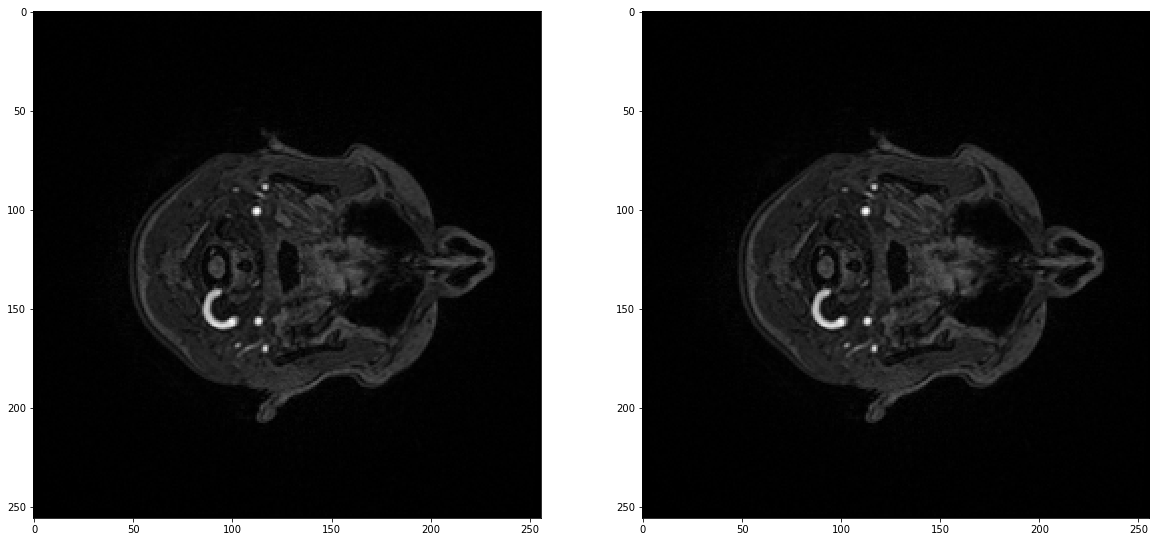

------------------------------------------------------------------------------------------------------------------------


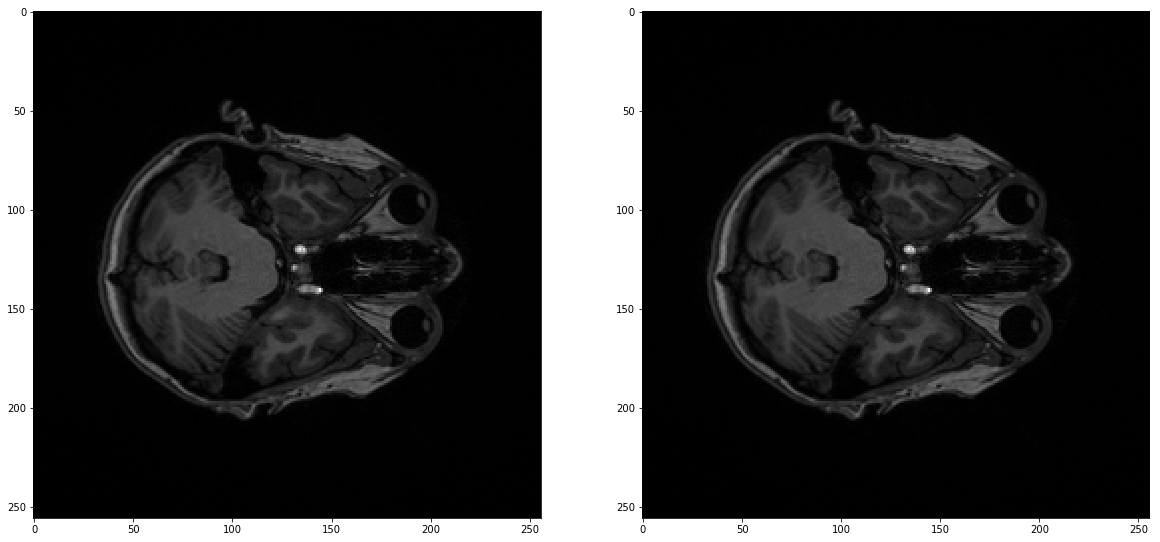

------------------------------------------------------------------------------------------------------------------------


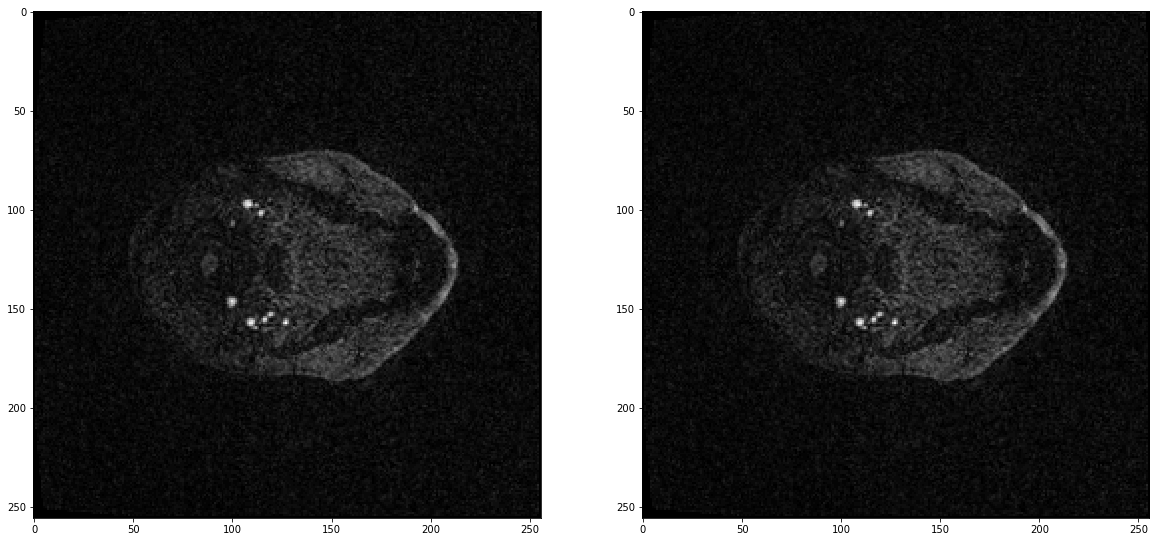

------------------------------------------------------------------------------------------------------------------------


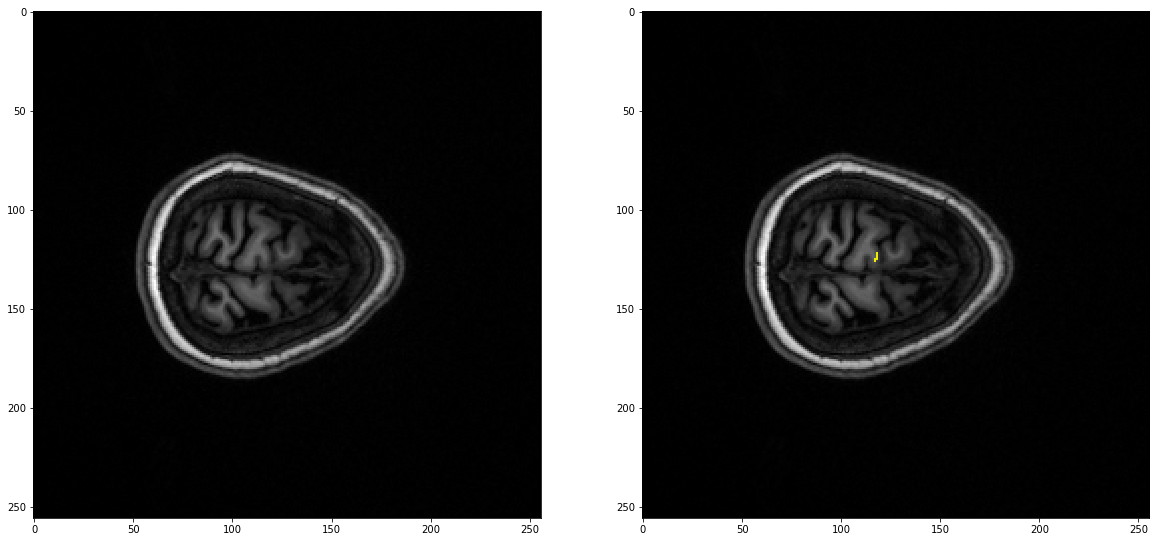

------------------------------------------------------------------------------------------------------------------------


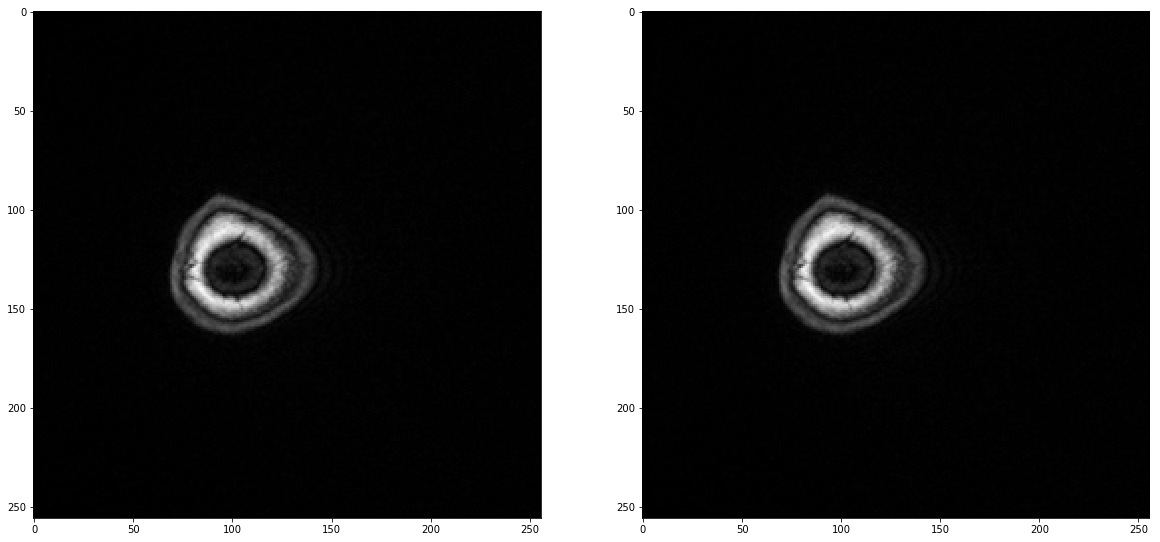

------------------------------------------------------------------------------------------------------------------------


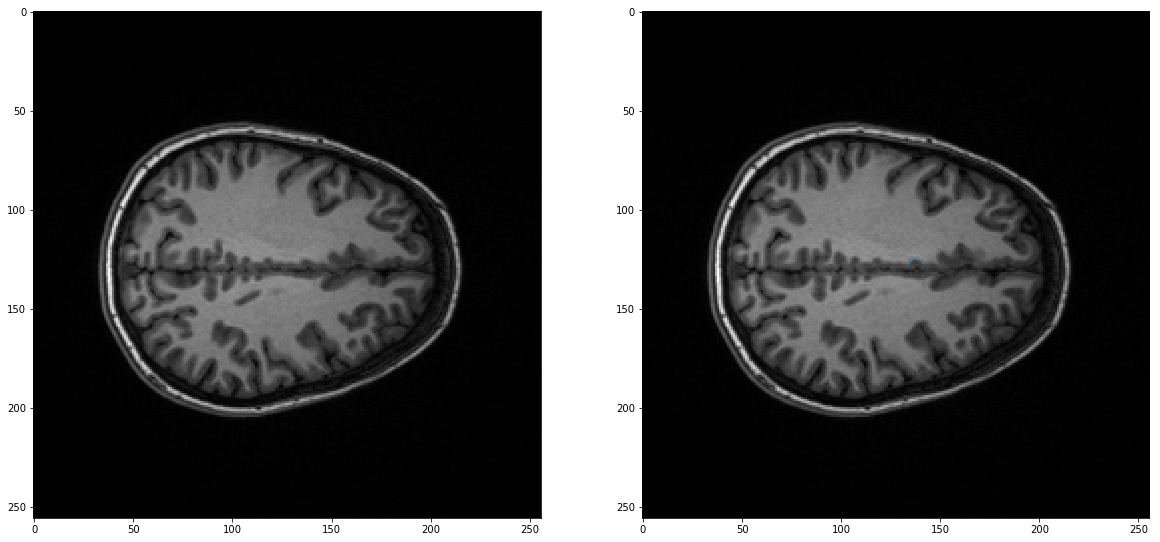

------------------------------------------------------------------------------------------------------------------------


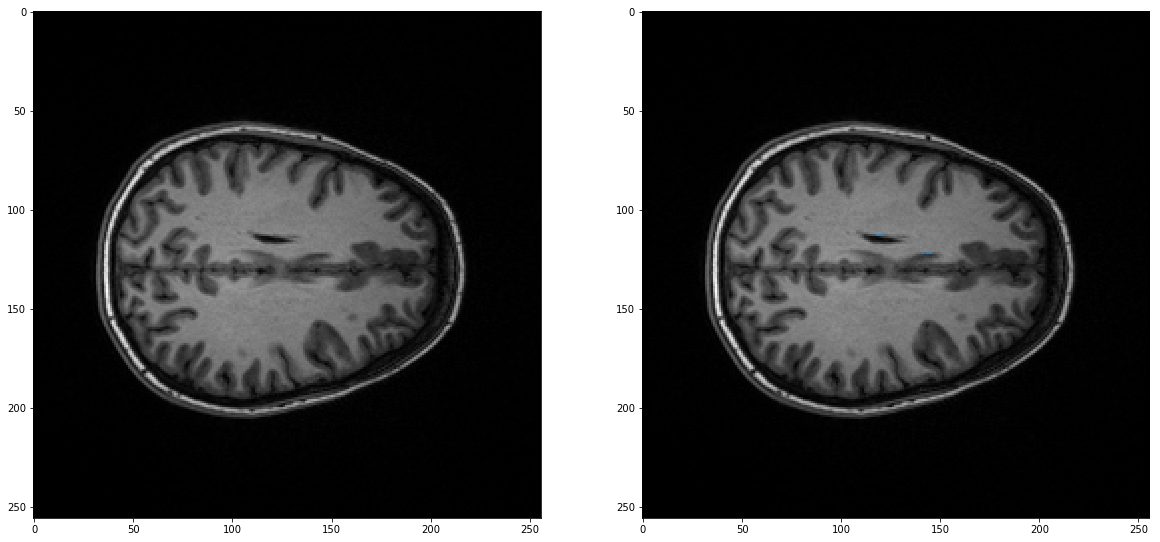

------------------------------------------------------------------------------------------------------------------------


In [98]:
visualize_tissue([0,1,2,3,4,5,6,7,8,9,10,11])

	 	 Original MRI 	 	  	 	 	 	 Predictions


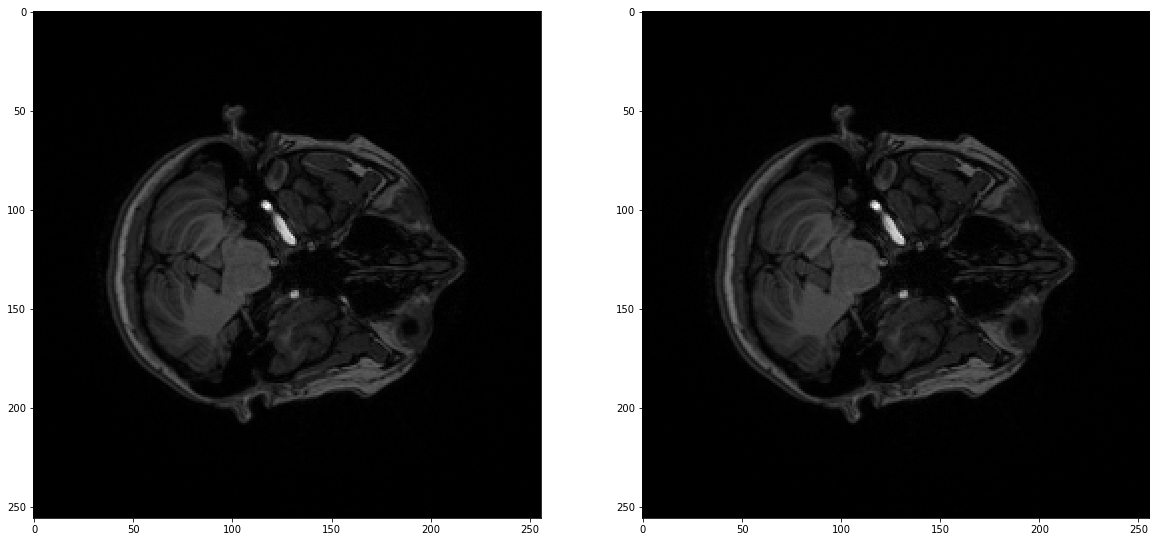

------------------------------------------------------------------------------------------------------------------------


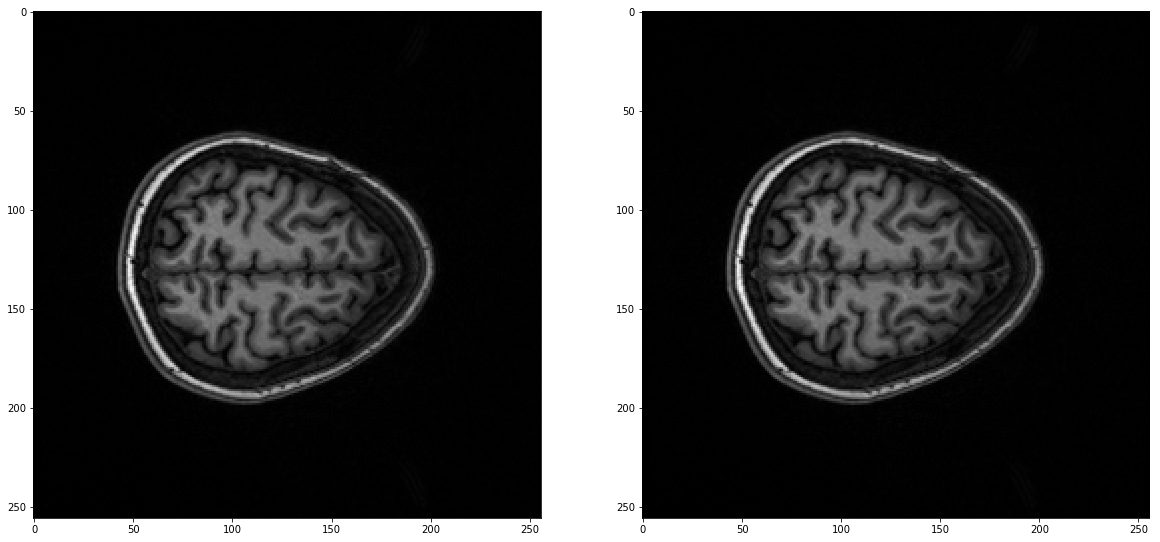

------------------------------------------------------------------------------------------------------------------------


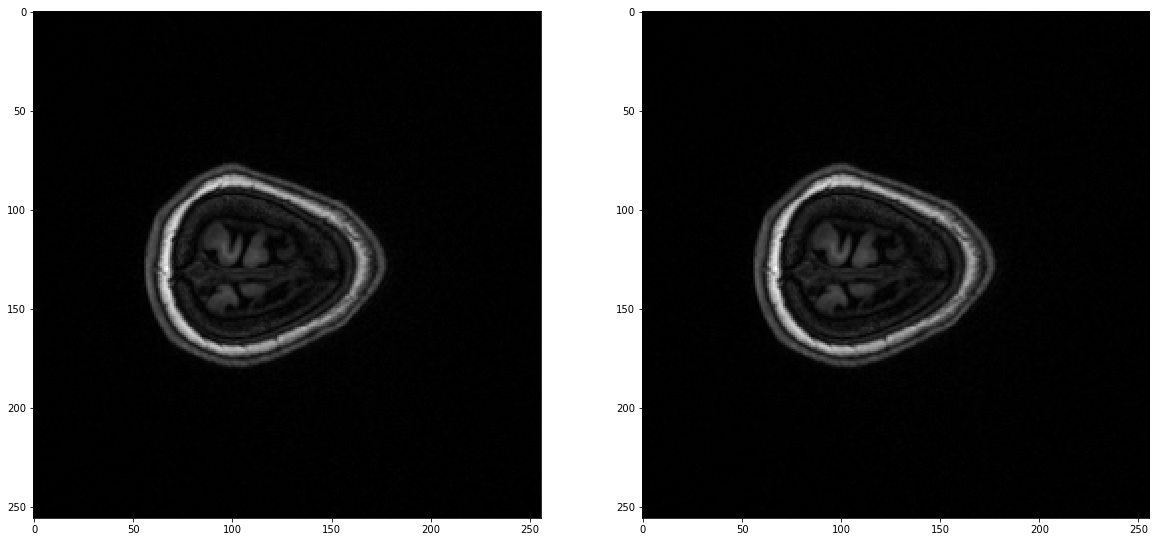

------------------------------------------------------------------------------------------------------------------------


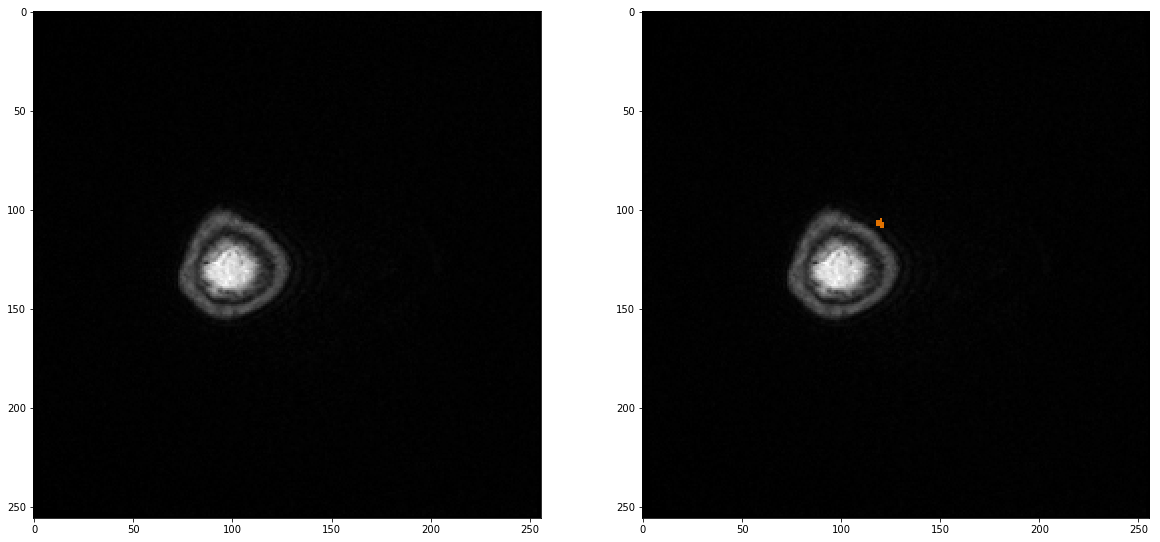

------------------------------------------------------------------------------------------------------------------------


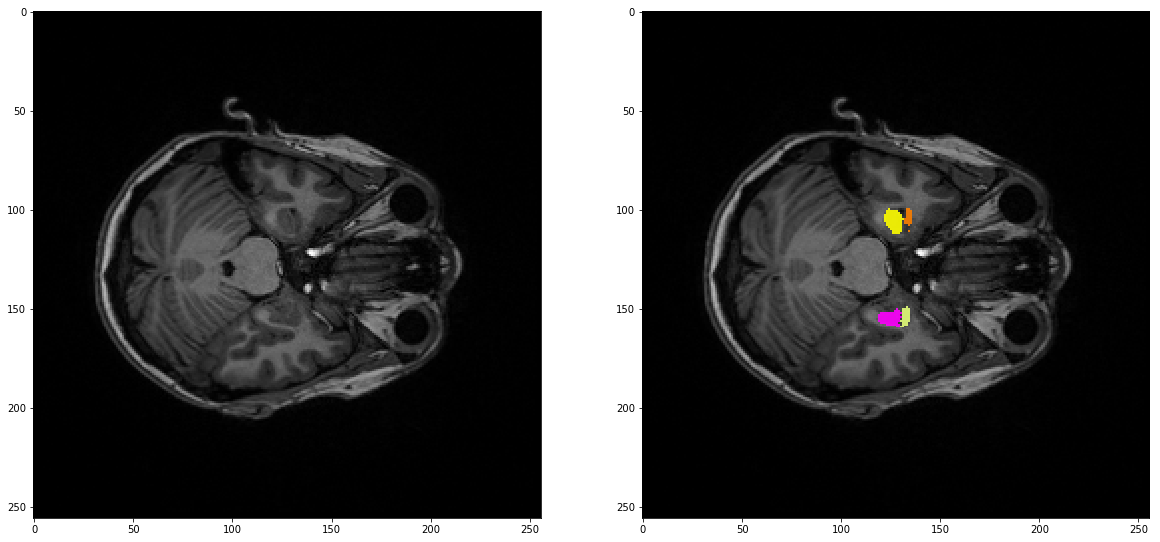

------------------------------------------------------------------------------------------------------------------------


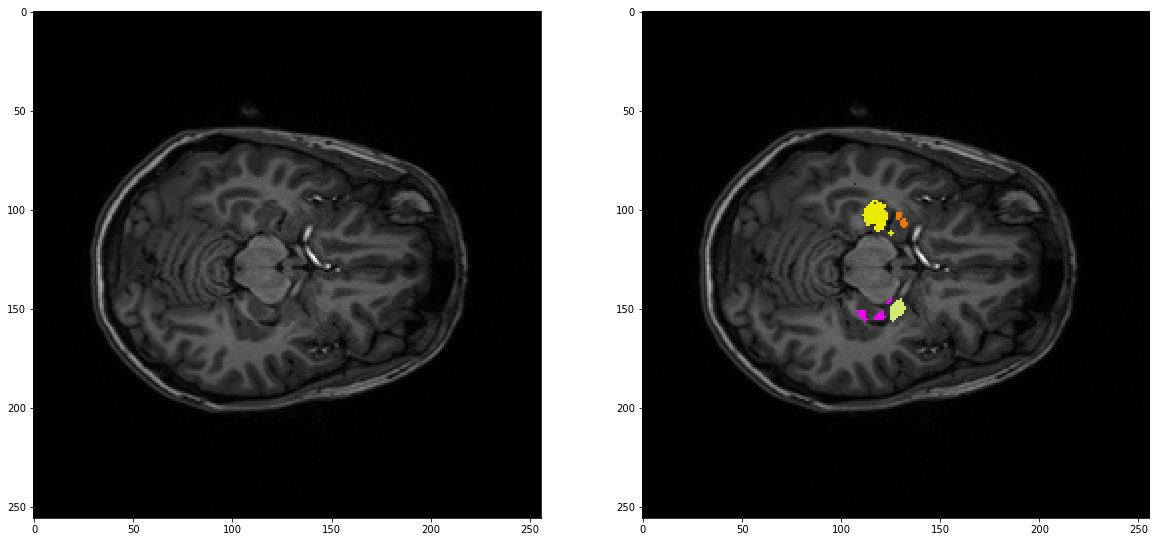

------------------------------------------------------------------------------------------------------------------------


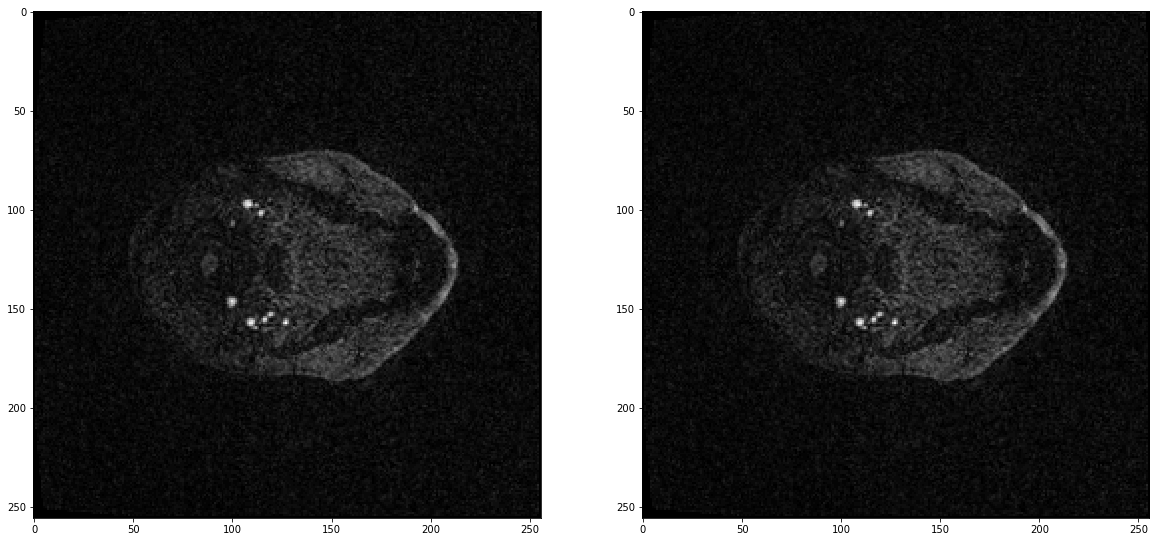

------------------------------------------------------------------------------------------------------------------------


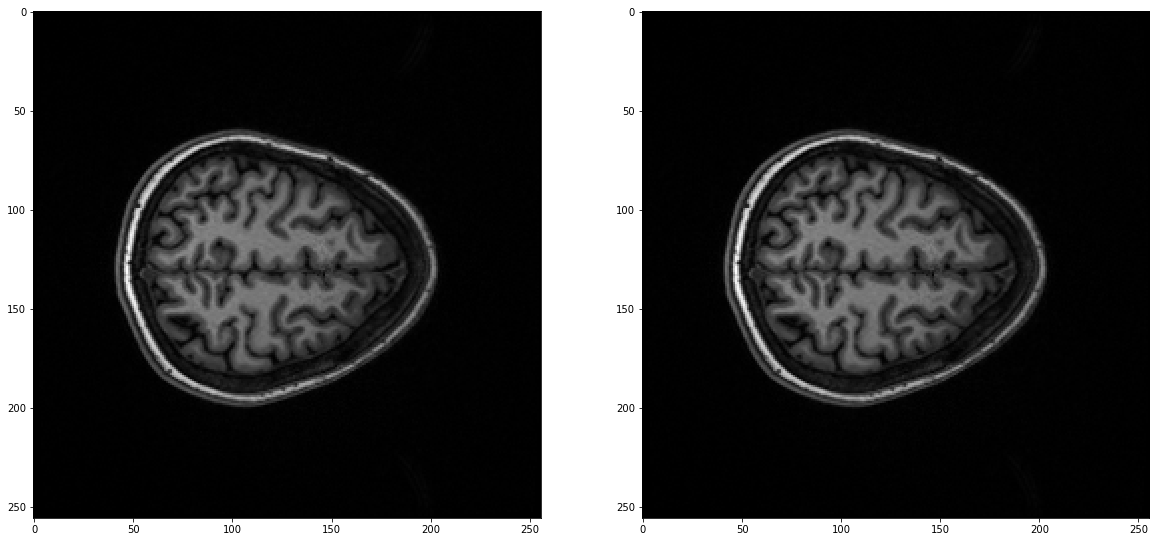

------------------------------------------------------------------------------------------------------------------------


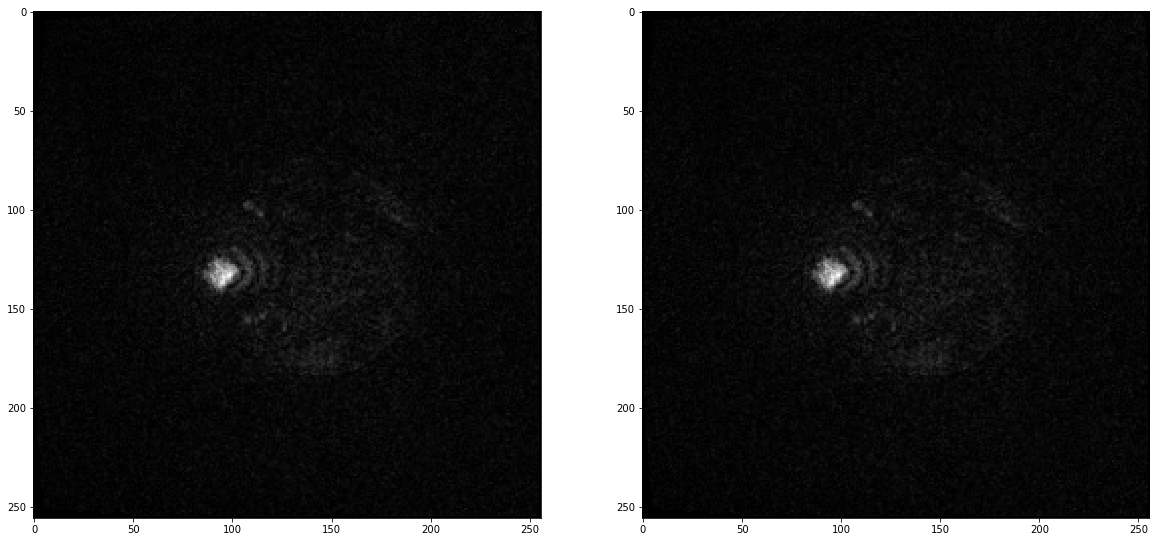

------------------------------------------------------------------------------------------------------------------------


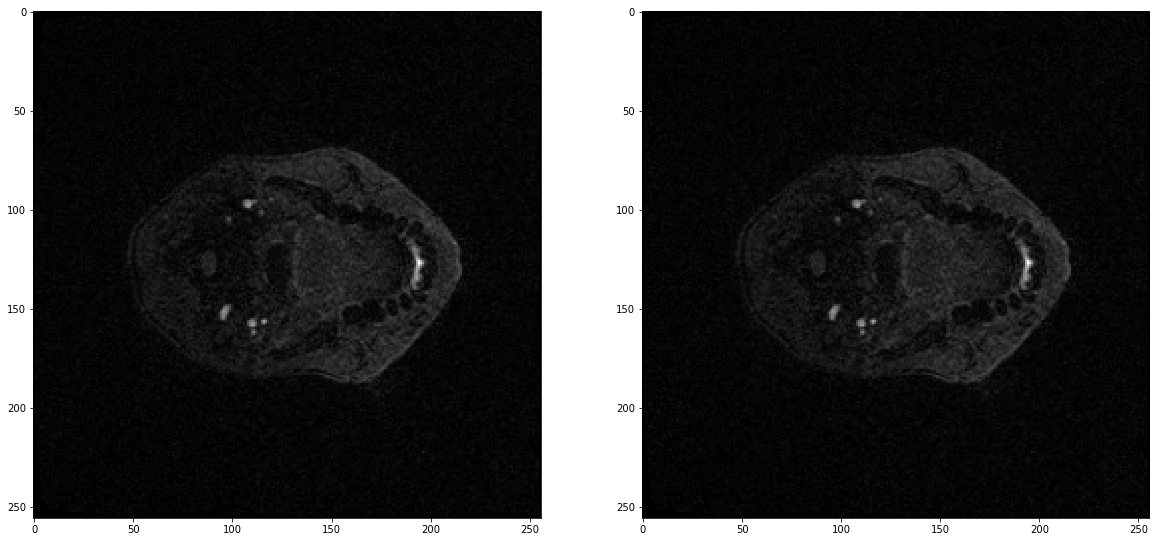

------------------------------------------------------------------------------------------------------------------------


In [99]:
visualize_tissue([0,1,2,3,4,5,6,7,8,9,10,11])

	 	 Original MRI 	 	  	 	 	 	 Predictions


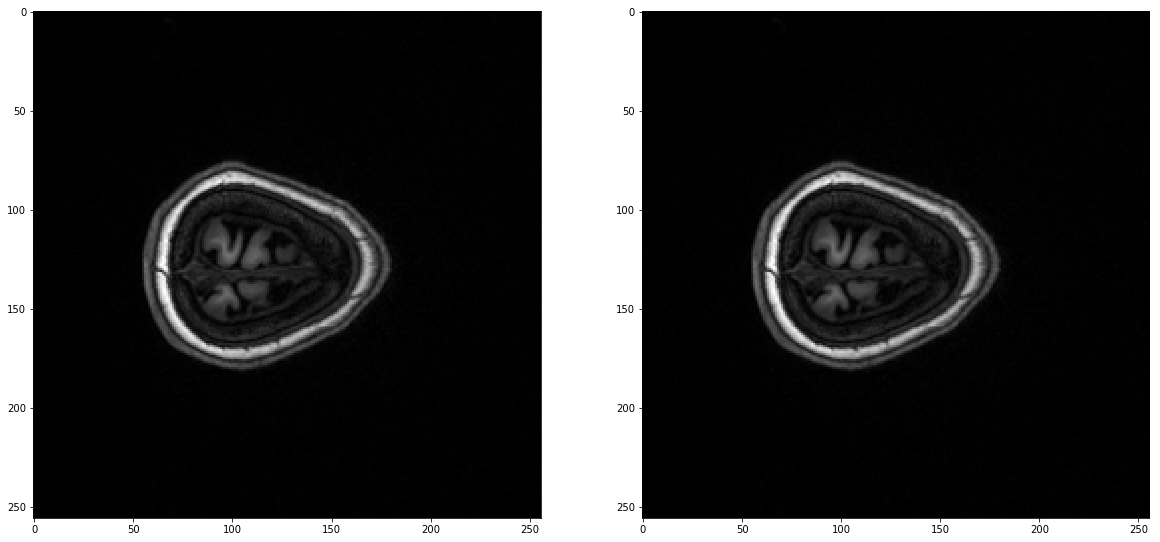

------------------------------------------------------------------------------------------------------------------------


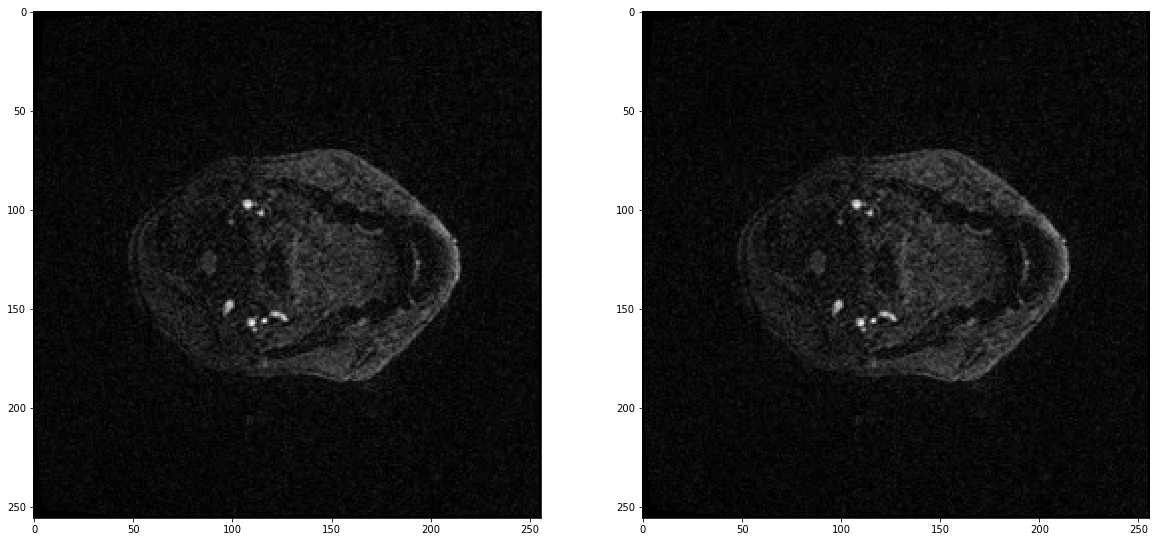

------------------------------------------------------------------------------------------------------------------------


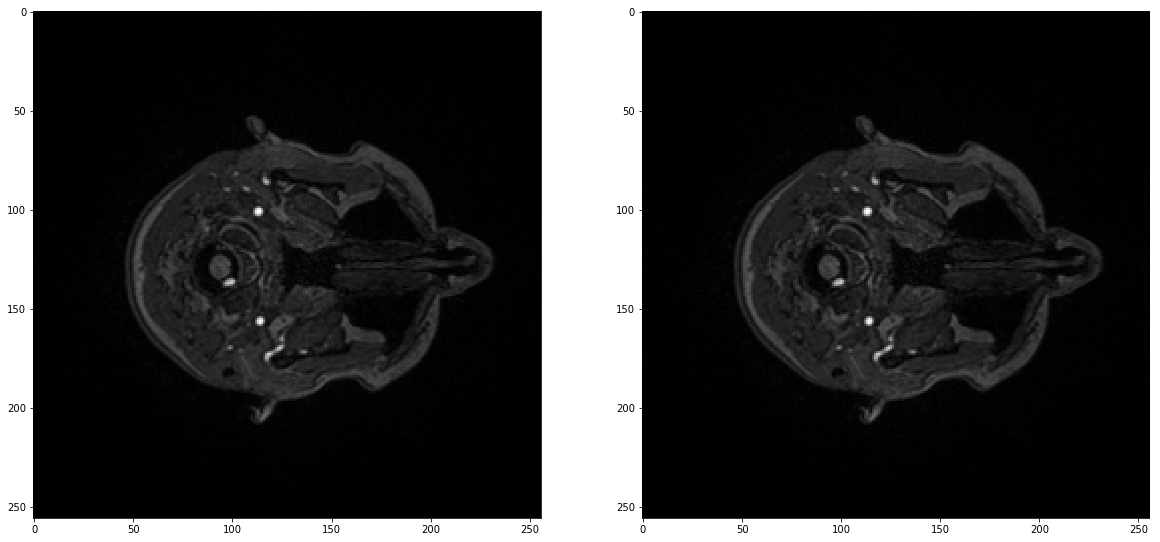

------------------------------------------------------------------------------------------------------------------------


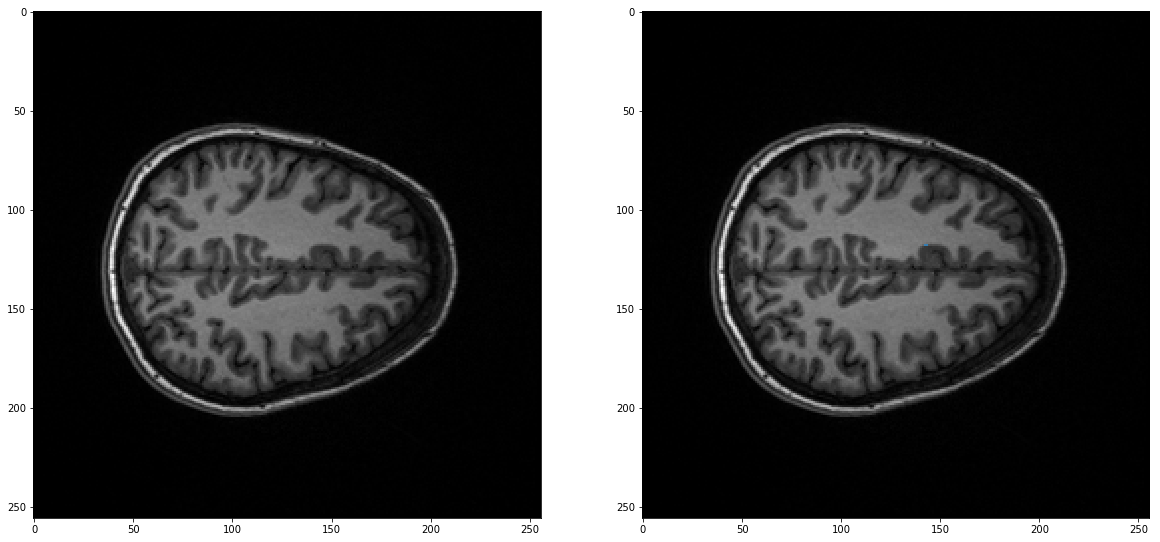

------------------------------------------------------------------------------------------------------------------------


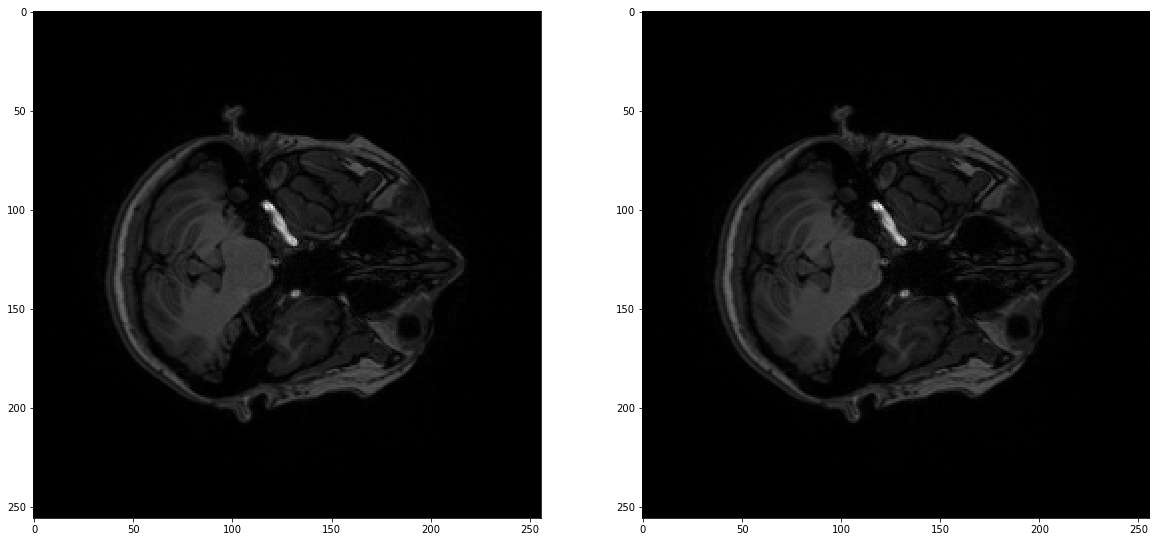

------------------------------------------------------------------------------------------------------------------------


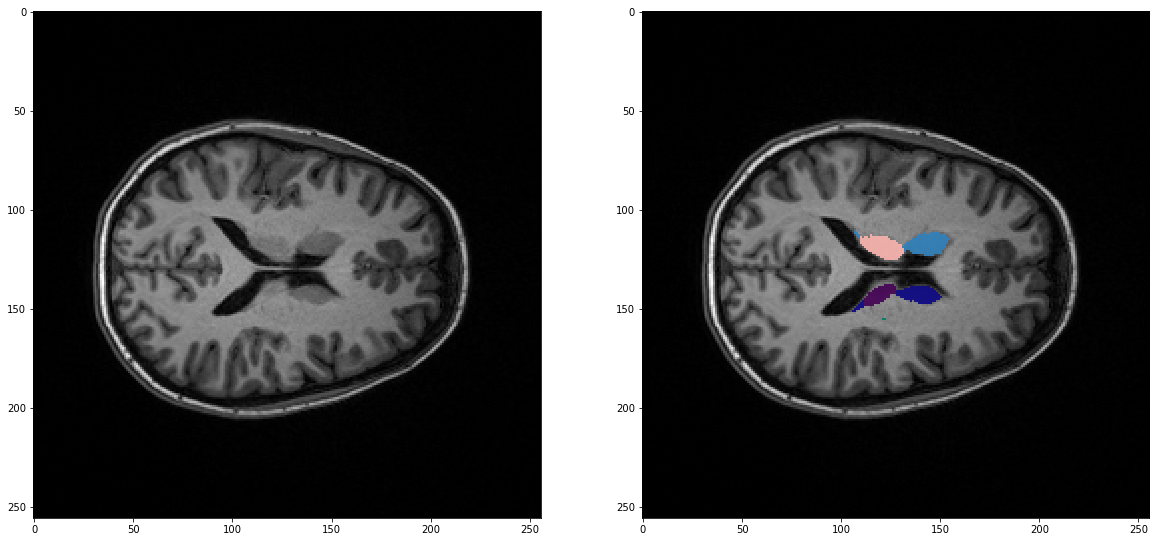

------------------------------------------------------------------------------------------------------------------------


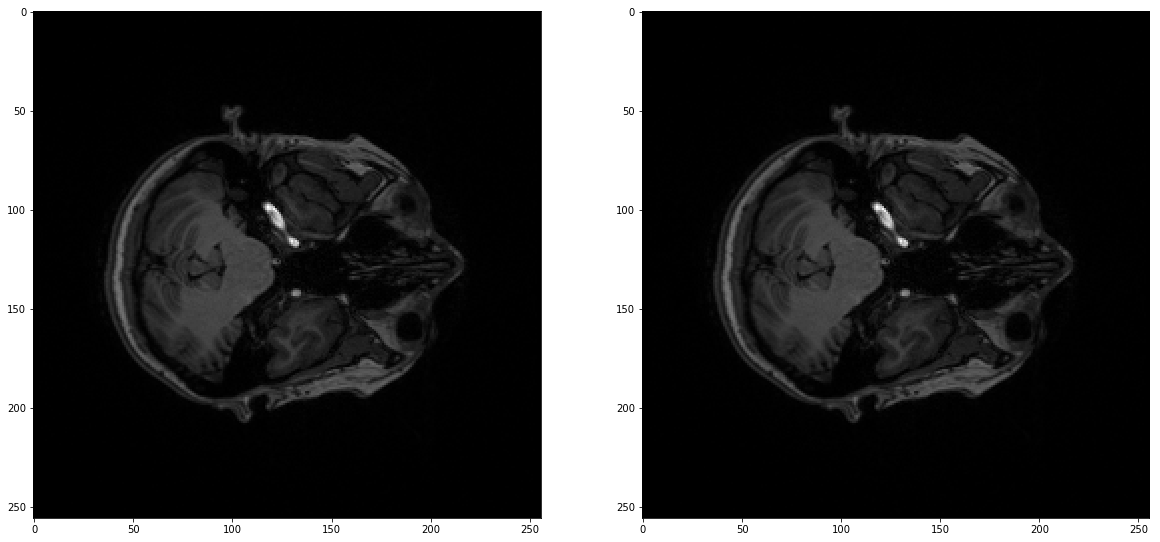

------------------------------------------------------------------------------------------------------------------------


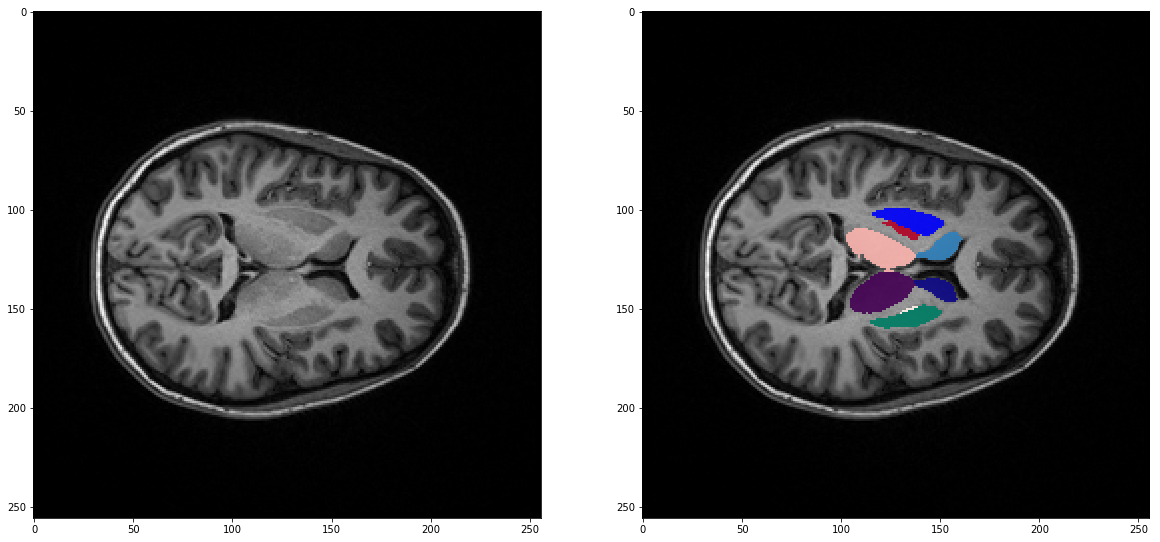

------------------------------------------------------------------------------------------------------------------------


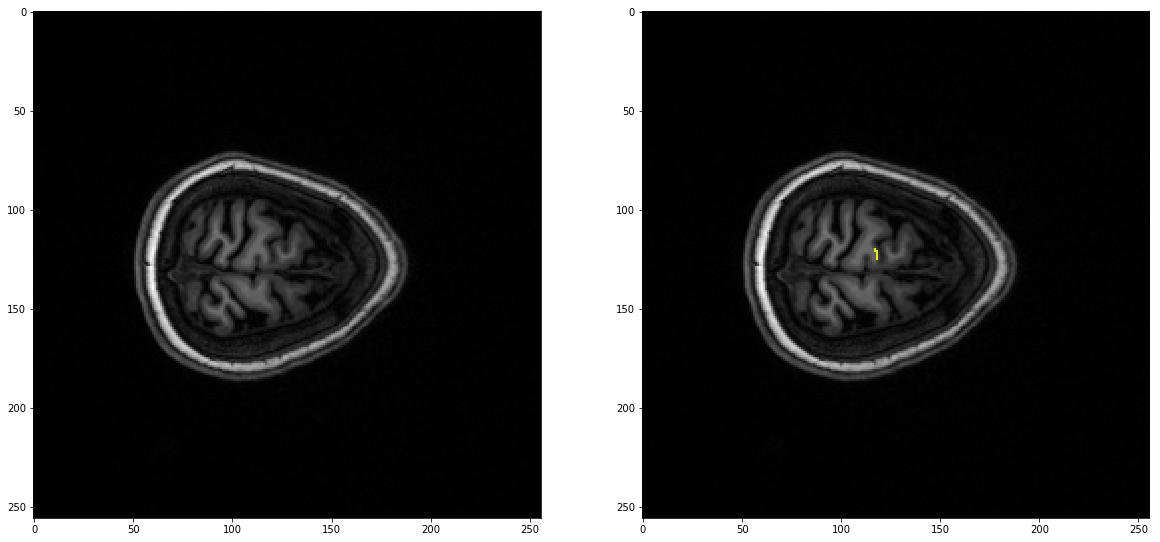

------------------------------------------------------------------------------------------------------------------------


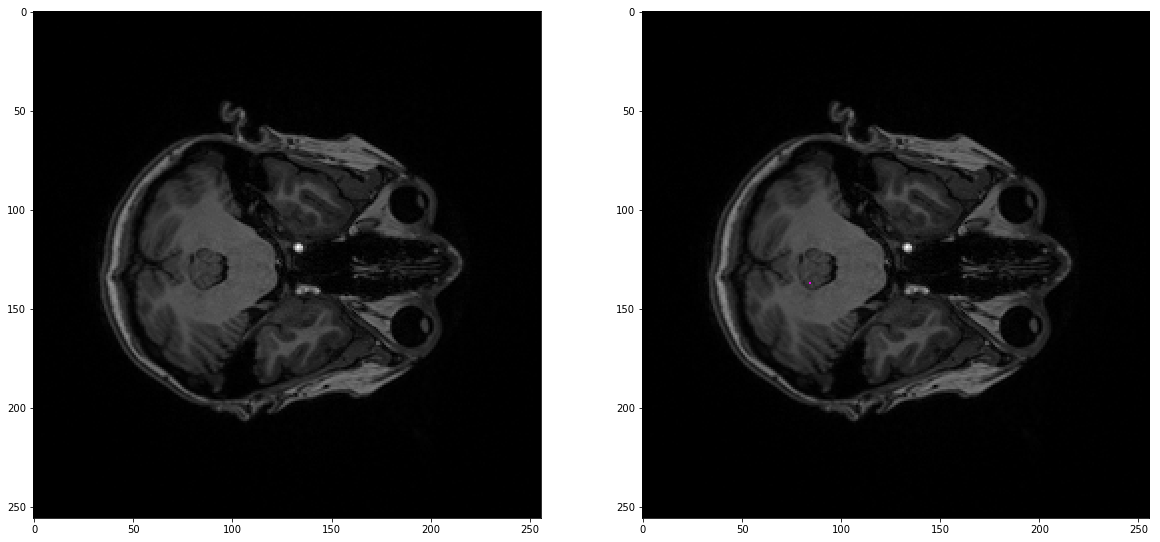

------------------------------------------------------------------------------------------------------------------------


In [100]:
visualize_tissue([0,1,2,3,4,5,6,7,8,9,10,11])

	 	 Original MRI 	 	  	 	 	 	 Predictions


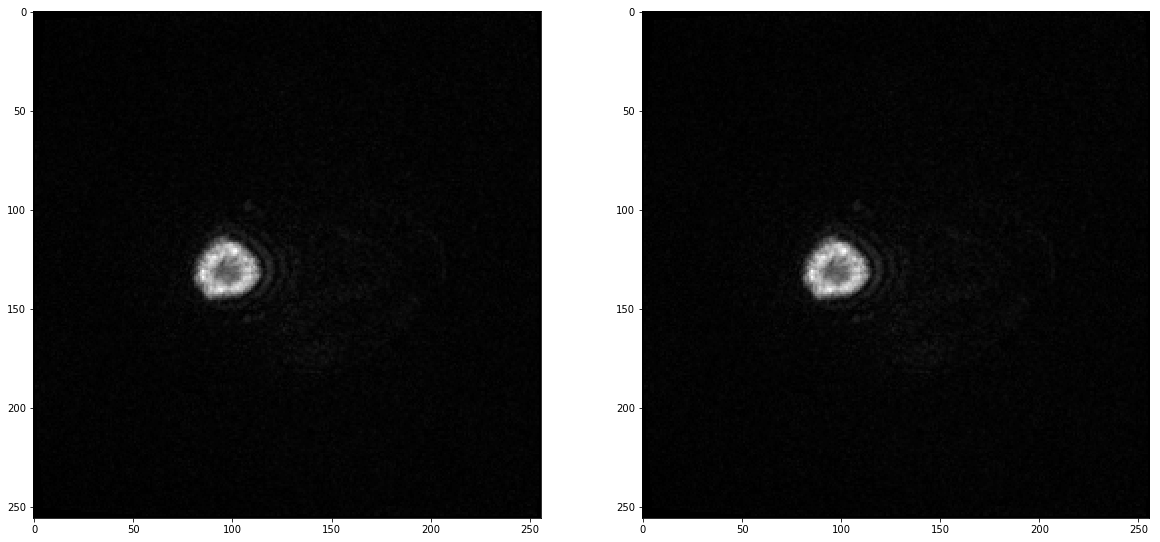

------------------------------------------------------------------------------------------------------------------------


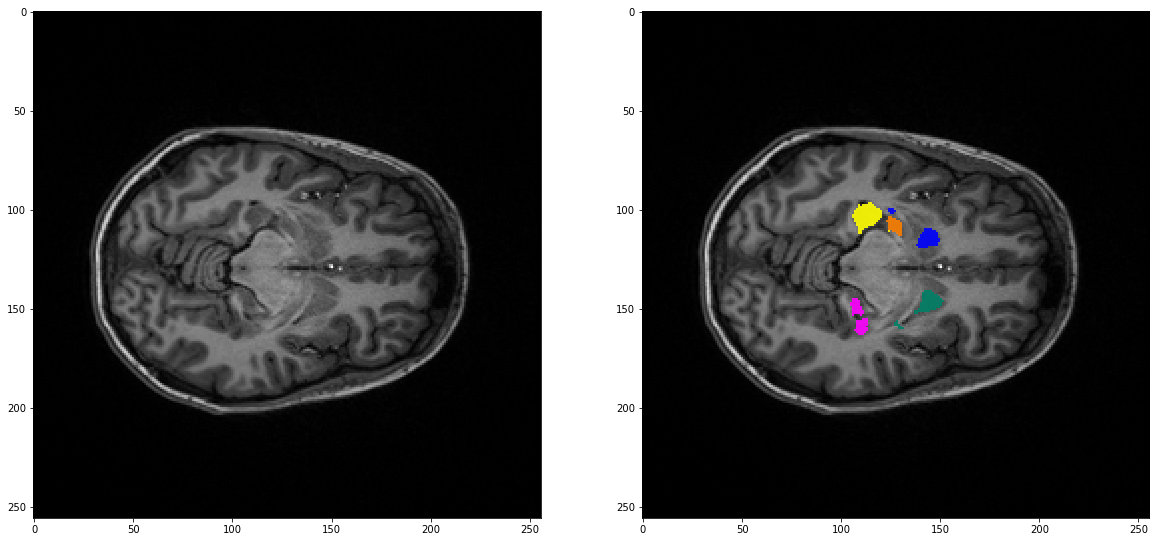

------------------------------------------------------------------------------------------------------------------------


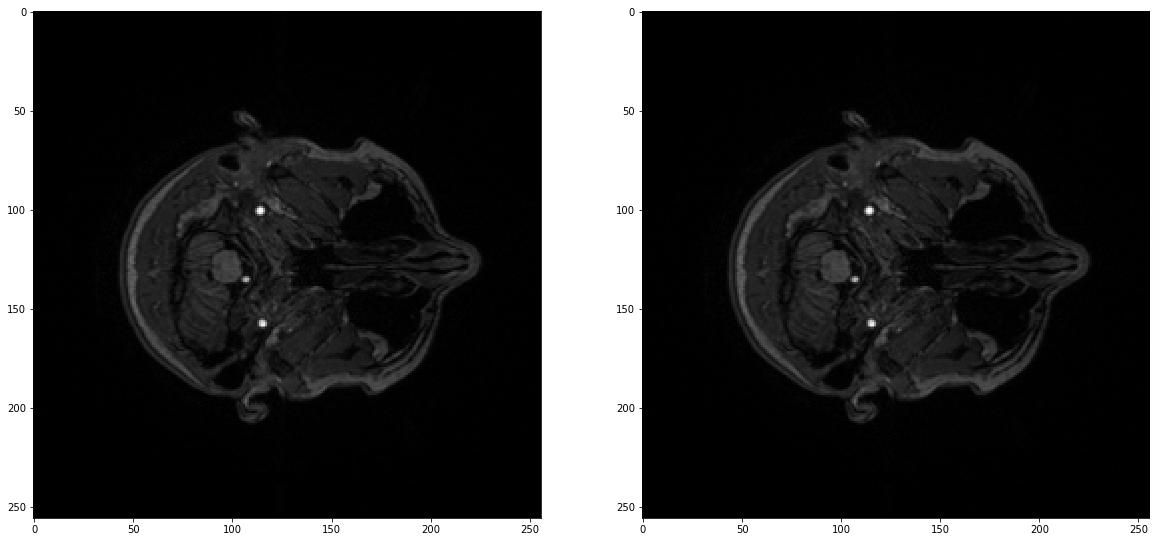

------------------------------------------------------------------------------------------------------------------------


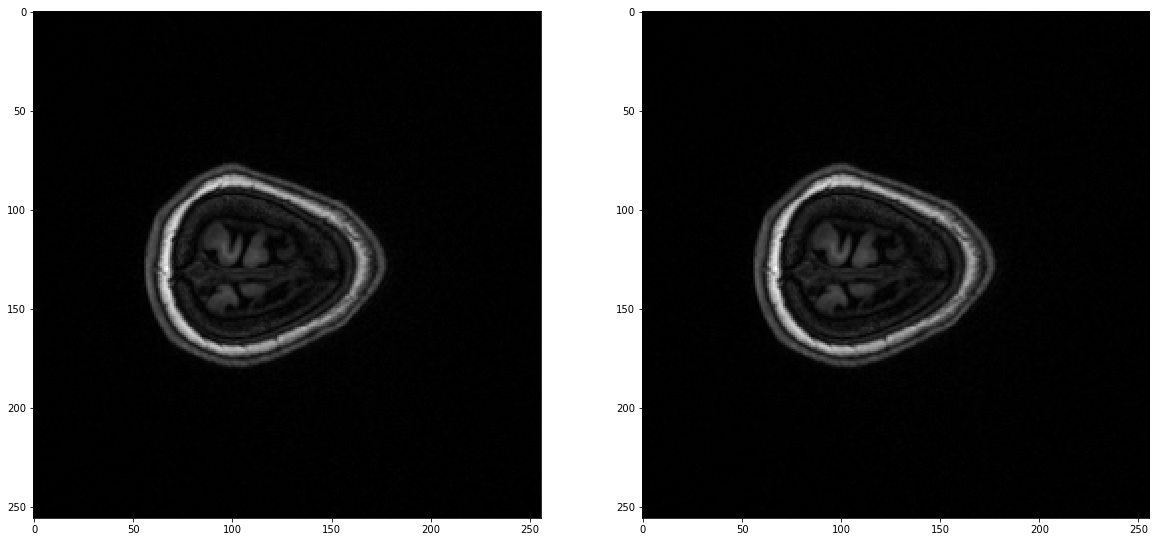

------------------------------------------------------------------------------------------------------------------------


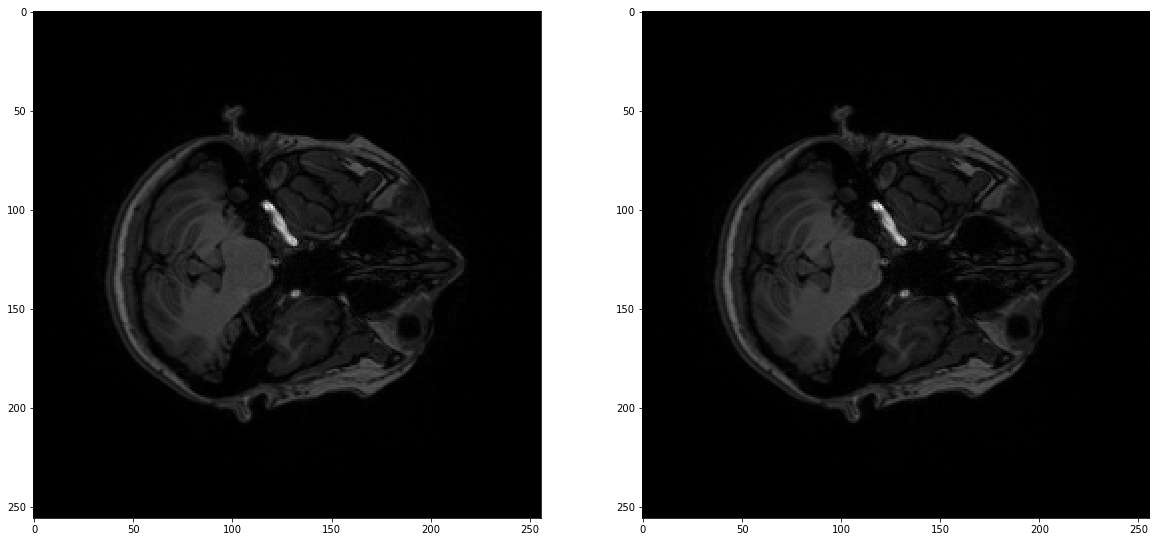

------------------------------------------------------------------------------------------------------------------------


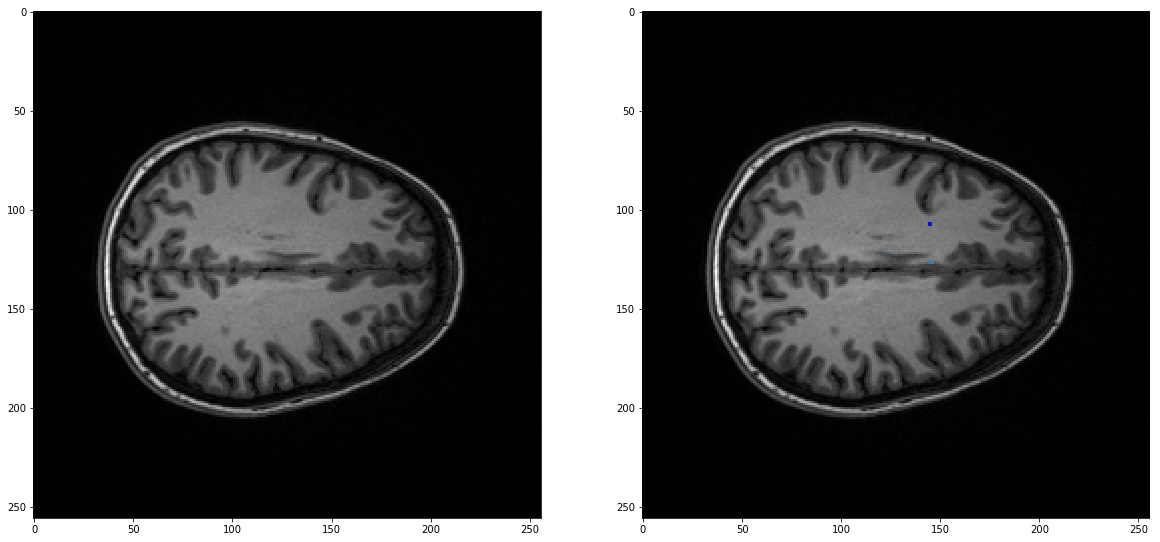

------------------------------------------------------------------------------------------------------------------------


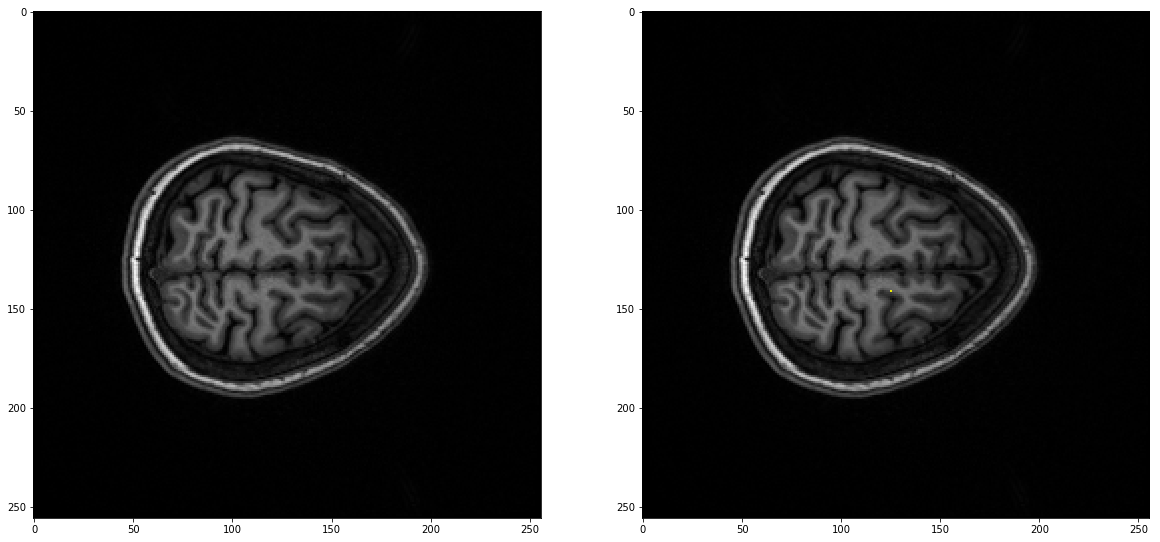

------------------------------------------------------------------------------------------------------------------------


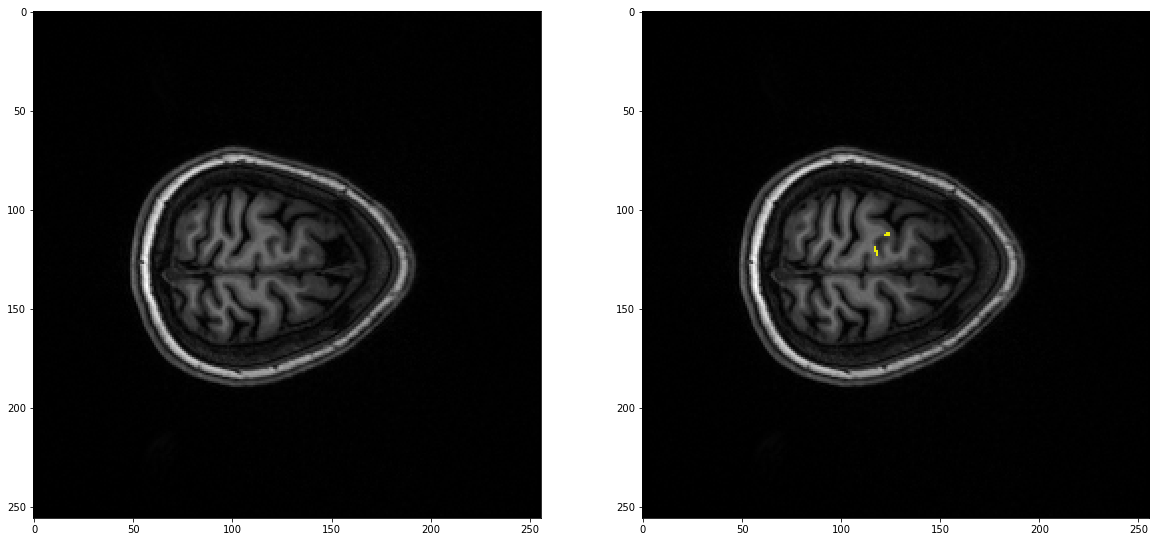

------------------------------------------------------------------------------------------------------------------------


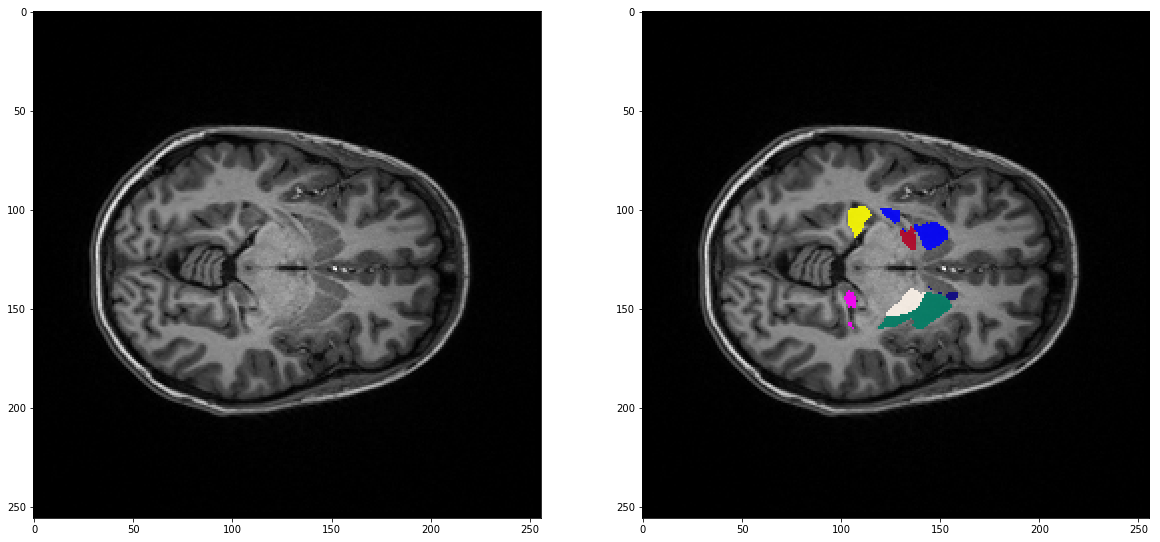

------------------------------------------------------------------------------------------------------------------------


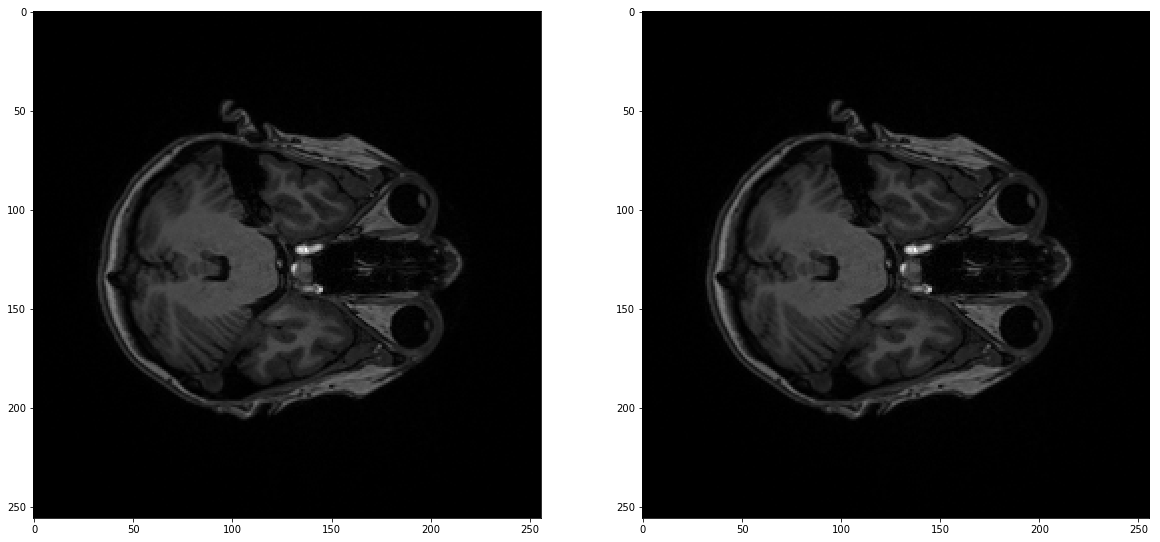

------------------------------------------------------------------------------------------------------------------------


In [102]:
visualize_tissue([0,1,2,3,4,5,6,7,8,9,10,11])

	 	 Original MRI 	 	  	 	 	 	 Predictions


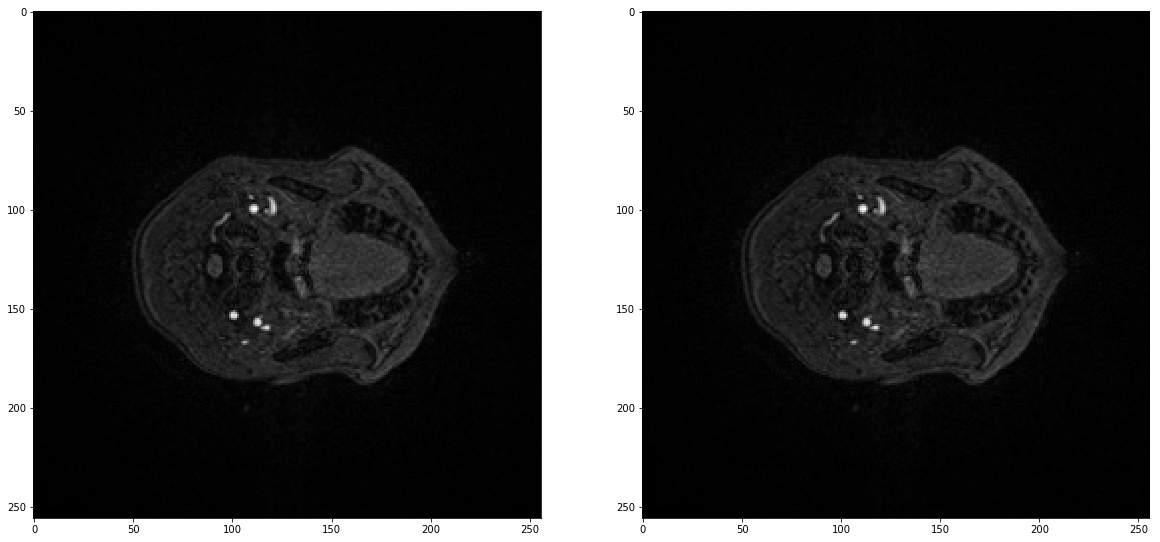

------------------------------------------------------------------------------------------------------------------------


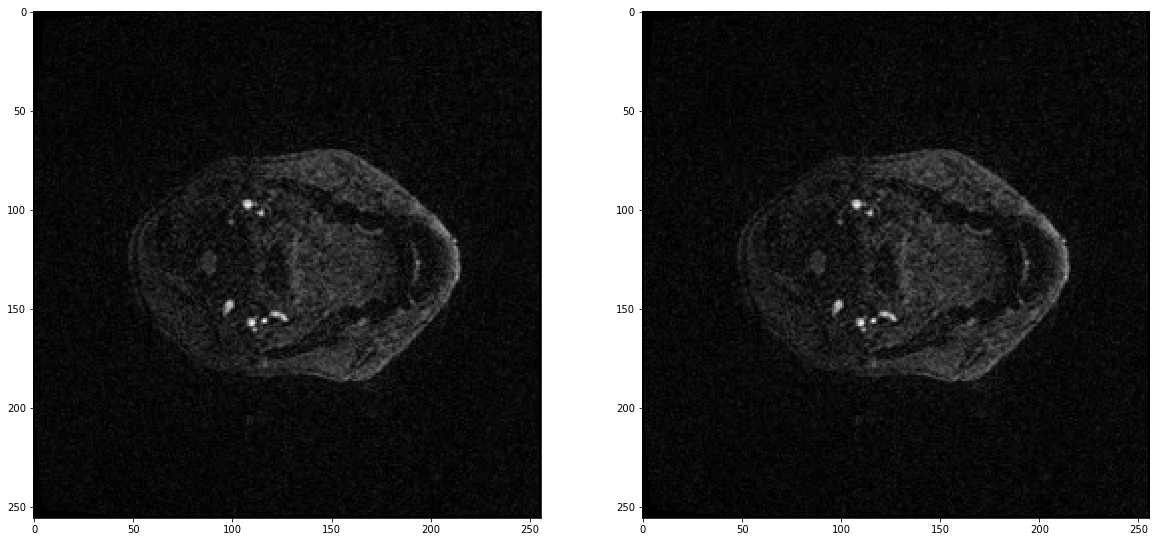

------------------------------------------------------------------------------------------------------------------------


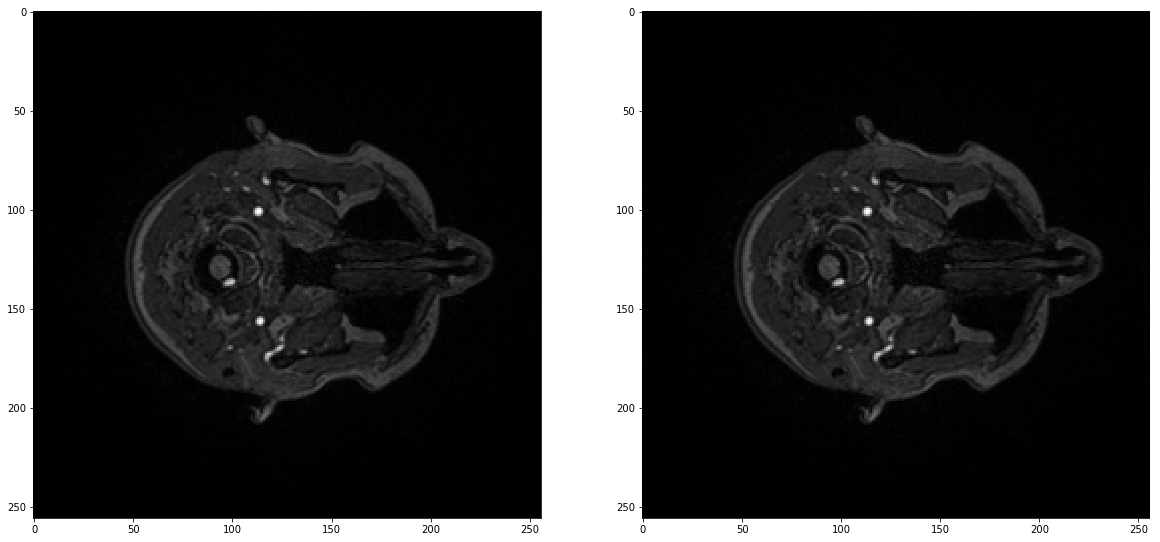

------------------------------------------------------------------------------------------------------------------------


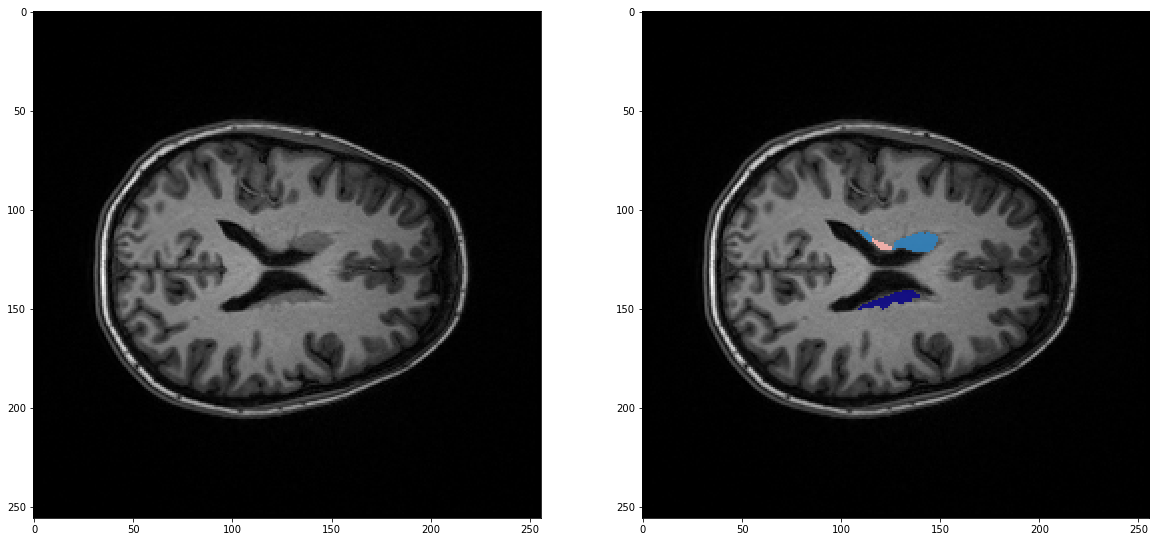

------------------------------------------------------------------------------------------------------------------------


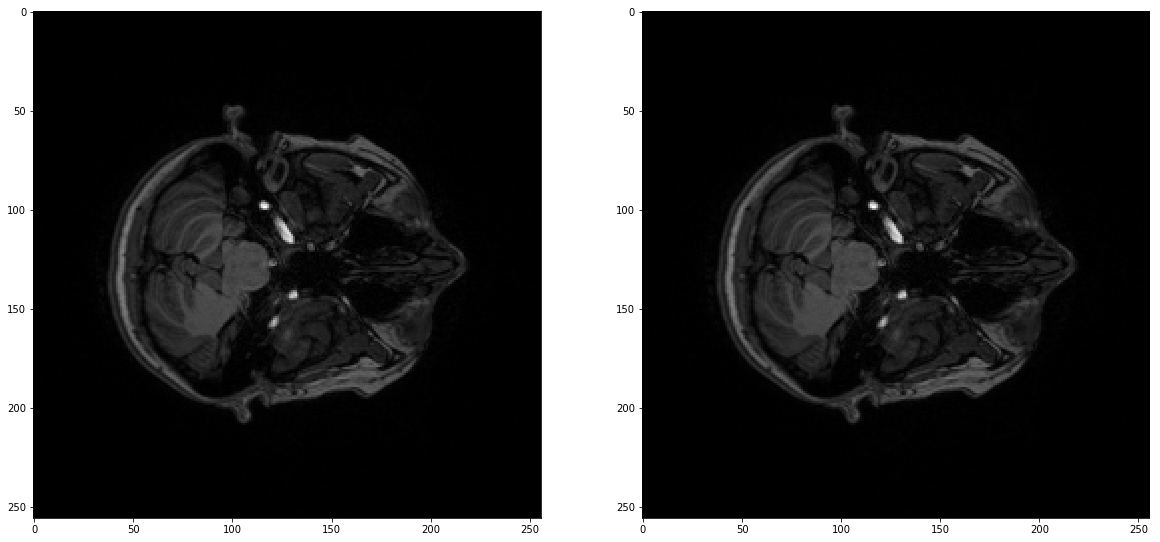

------------------------------------------------------------------------------------------------------------------------


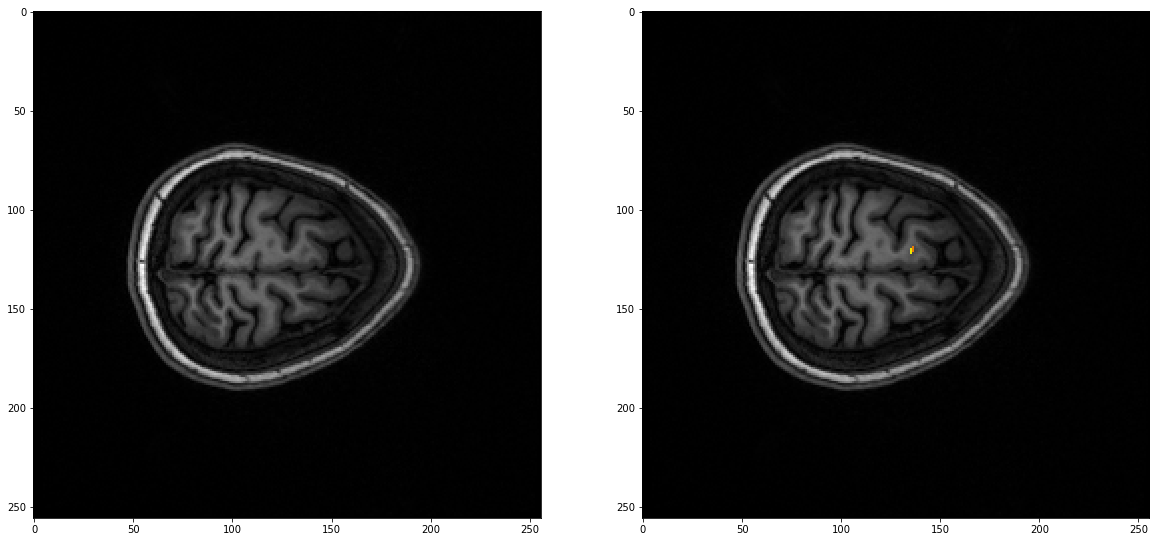

------------------------------------------------------------------------------------------------------------------------


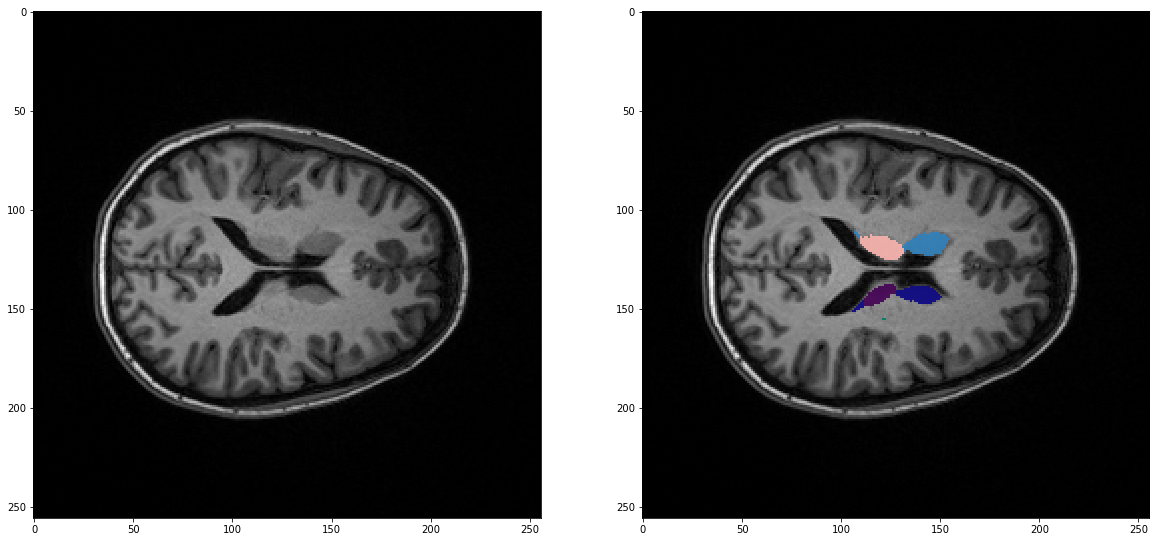

------------------------------------------------------------------------------------------------------------------------


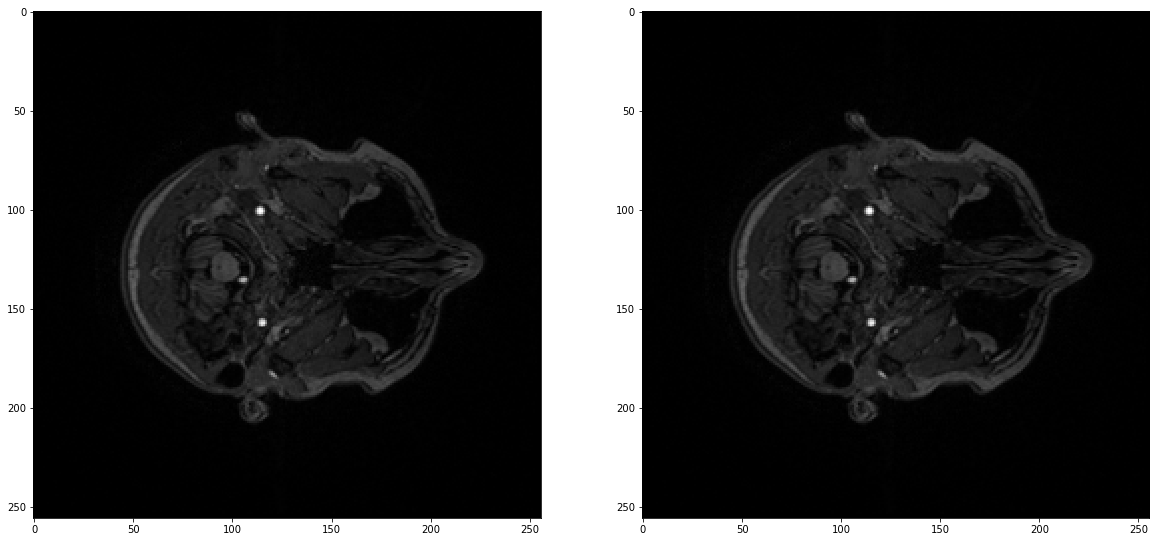

------------------------------------------------------------------------------------------------------------------------


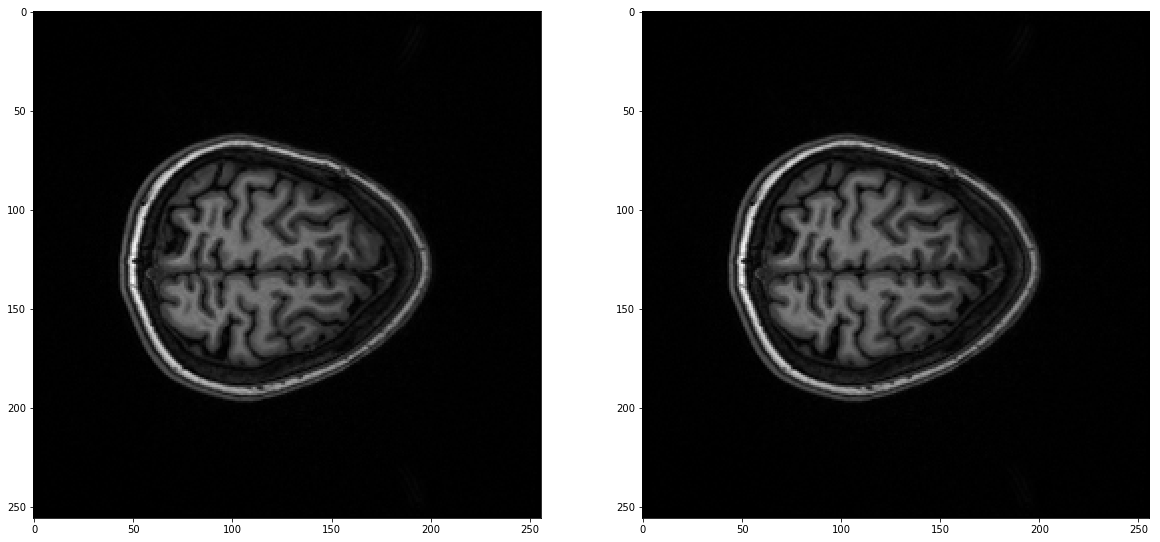

------------------------------------------------------------------------------------------------------------------------


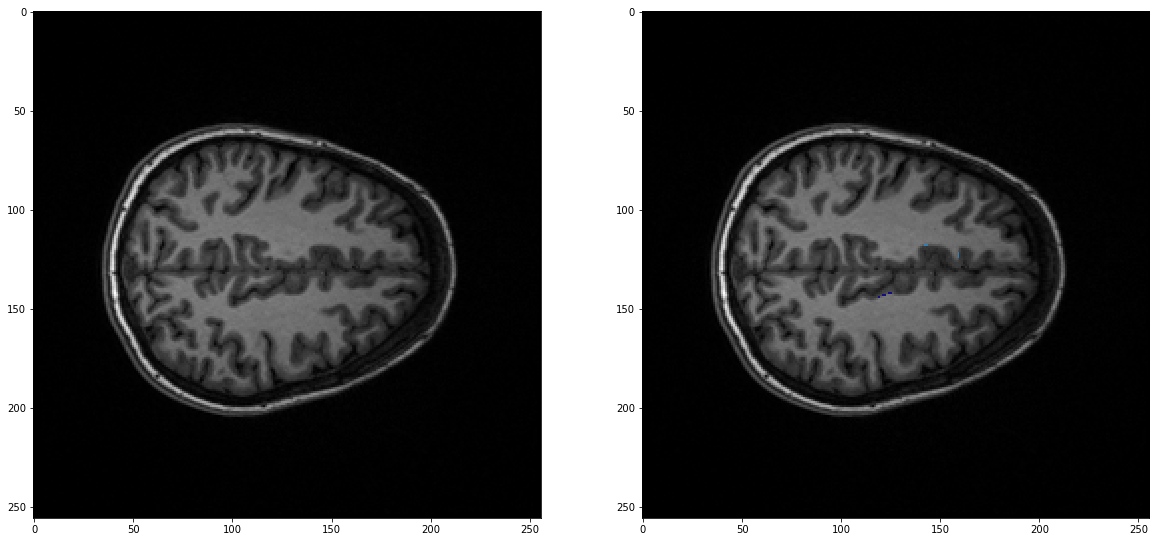

------------------------------------------------------------------------------------------------------------------------


In [103]:
visualize_tissue([0,1,2,3,4,5,6,7,8,9,10,11])